# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [x] [Exploring the data](#explore)
- [x] [Which training sample is best?](#sample)
- [x] [Which image representation is best?](#repr)
- [ ] [Which network architecture works best?](#arch)
- [x] [Which channel configuration is best?](#channel)
- [x] [Which categorisation is best?](#cat)
- [x] [Does escapes help cosmic classifier?](#cosmic)
- [x] [Does primary count help beam classifier?](#beam)
- [x] [Does lepton/hadronic energy help neutrino energy estimation?](#energy_chan)
- [x] [Does vertex/escapes energy help neutrino energy estimation?](#energy_par)
- [ ] [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [ ] [Model calibration sensitivity: factor](#calib_factor)
- [ ] [Model calibration sensitivity: abs](#calib_abs)
- [ ] [Model calibration sensitivity: noise](#calib_noise)
- [x] [Clustering: cosmic classification](#cosmic_cluster)
- [x] [Clustering: beam classification](#beam_cluster)
- [ ] [Explanation: cosmic/beam/energy](#explain)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/analysis/config.yaml"
save_path = "./data/output/"
nuel_map_file = "/unix/chips/jtingey/prod/nuel_all_numuflux/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/prod/numu_all_numuflux/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/prod/cosmics/map/chips_1200/selected_000_sim_map.root"
old_nuel_file = "./data/input/old_reco/old_reco_el.root"
old_numu_file = "./data/input/old_reco/old_reco_mu.root"
vac_osc_file_zero_f = "./data/input/oscillations/vac_osc_cp_zero.root"
vac_osc_file_plus_f = "./data/input/oscillations/vac_osc_cp_plushalfpi.root"
vac_osc_file_minus_f = "./data/input/oscillations/vac_osc_cp_minushalfpi.root"
matter_osc_file_zero_f = "./data/input/oscillations/matter_osc_cp_zero.root"
matter_osc_file_plus_f = "./data/input/oscillations/matter_osc_cp_plushalfpi.root"
matter_osc_file_minus_f = "./data/input/oscillations/matter_osc_cp_minushalfpi.root"
total_flux_events = 1822592
total_uniform_events = 3086208
total_cosmic_events = 1327744

In [2]:
# Standard inports
import os
import logging
import importlib
import copy
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}

style = hep.style.ROOT
del style['xaxis.labellocation']
del style['yaxis.labellocation']
plt.style.use([style, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
s_both_ev, s_both_out = chipsnet.utils.evaluate(config, "sample_both_cosmic")
s_flux_ev, s_flux_out = chipsnet.utils.evaluate(config, "sample_flux_cosmic")
s_uniform_ev, s_uniform_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic")
flux_ev, flux_out = chipsnet.utils.evaluate(config, "flux_cosmic")


************************ Evaluating sample_both_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (94917,0.03533), (0,0.00000), (69948,17.30854)
Cuts:    (62860,0.95634), (67755,0.93258), (34143,0.71625), (14324,0.20478)
took 237.56 seconds

************************ Evaluating sample_flux_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (70793,0.04737), (0,0.00000), (118709,10.19887)
Cuts:    (54668,0.94714), (55707,0.91320), (12242,0.65924), (24187,0.20375)
took 278.64 seconds

************************ Evaluating sample_uniform_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (91902,0.03649), (0,0.00000), (84312,14.35973)
Cuts:    (52261,0.95786), (59438,0.93097), (40454,0.75923), (17300,0.20519)
took 315.42 seconds

************************ Evaluating flux_cosmic ************************
Weights: (24554,0.00158), (37292,0.00007), (43183,0.07765), (60569,0.00121), (50133,24.14972)
Cuts:    (83611,0.95945), (83214,0.93247), (20348,0

In [5]:
# Get oscillation arrays...
vac_osc_file_zero = uproot.open(vac_osc_file_zero_f)
vac_osc_file_plus = uproot.open(vac_osc_file_plus_f)
vac_osc_file_minus = uproot.open(vac_osc_file_minus_f)
matter_osc_file_zero = uproot.open(matter_osc_file_zero_f)
matter_osc_file_plus = uproot.open(matter_osc_file_plus_f)
matter_osc_file_minus = uproot.open(matter_osc_file_minus_f)

vac_numu_prop_zero = vac_osc_file_zero["hist_mumu"].values[113]
vac_nuel_prop_zero = vac_osc_file_zero["hist_mue"].values[113]
vac_numu_prop_plus = vac_osc_file_plus["hist_mumu"].values[113]
vac_nuel_prop_plus = vac_osc_file_plus["hist_mue"].values[113]
vac_numu_prop_minus = vac_osc_file_minus["hist_mumu"].values[113]
vac_nuel_prop_minus = vac_osc_file_minus["hist_mue"].values[113]

matter_numu_prop_zero = matter_osc_file_zero["hist_mumu"].values
matter_nuel_prop_zero = matter_osc_file_zero["hist_mue"].values
matter_numu_prop_plus = matter_osc_file_plus["hist_mumu"].values
matter_nuel_prop_plus = matter_osc_file_plus["hist_mue"].values
matter_numu_prop_minus = matter_osc_file_minus["hist_mumu"].values
matter_nuel_prop_minus = matter_osc_file_minus["hist_mue"].values

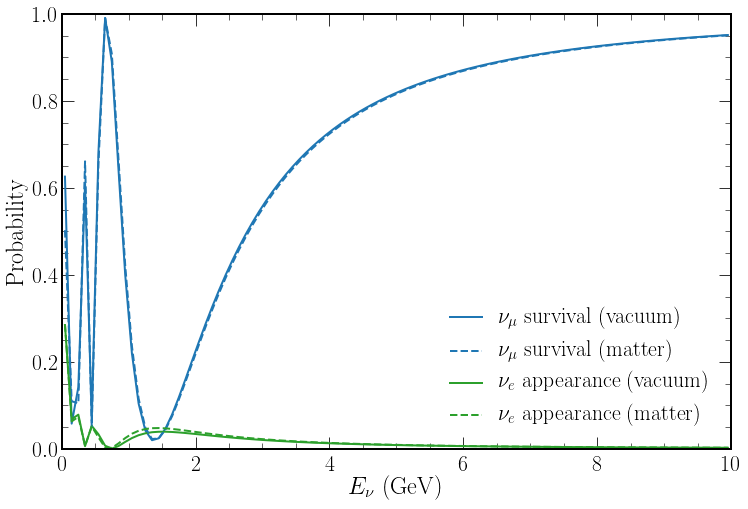

In [7]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
axs.plot(energies, vac_numu_prop_zero, color="tab:blue", linewidth=2)
axs.plot(energies, vac_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_numu_prop_zero, color="tab:blue", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2, linestyle="dashed")
axs.set_ylim(0, 1)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Probability", fontsize=24)
vac_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$\nu_{\mu}$ survival (vacuum)")
vac_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\nu_{e}$ appearance (vacuum)")
matter_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="dashed", label=r"$\nu_{\mu}$ survival (matter)")
matter_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\nu_{e}$ appearance (matter)")
axs.legend(handles=[vac_numu, matter_numu, vac_nuel, matter_nuel], loc="lower right")
chipsnet.plotting.save(save_path + "explore_osc_vac_vs_matter_probs")

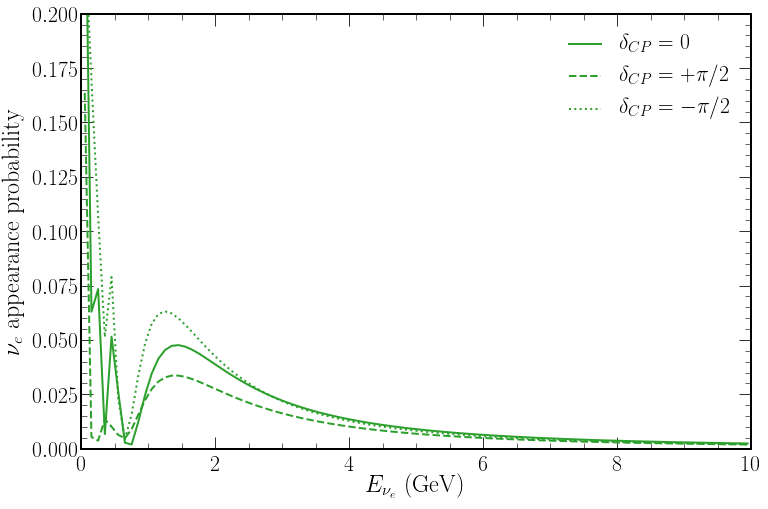

In [8]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_nuel_prop_plus, color="tab:green", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_minus, color="tab:green", linewidth=2, linestyle="dotted")
axs.set_ylim(0, 0.2)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=24)
axs.set_ylabel(r"$\nu_{e}$ appearance probability", fontsize=24)
zero_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\delta_{CP}=0$")
plus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\delta_{CP}=+\pi/2$")
minus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dotted", label=r"$\delta_{CP}=-\pi/2$")
axs.legend(handles=[zero_cp, plus_cp, minus_cp], loc="upper right")
chipsnet.plotting.save(save_path + "explore_osc_cp_probs")

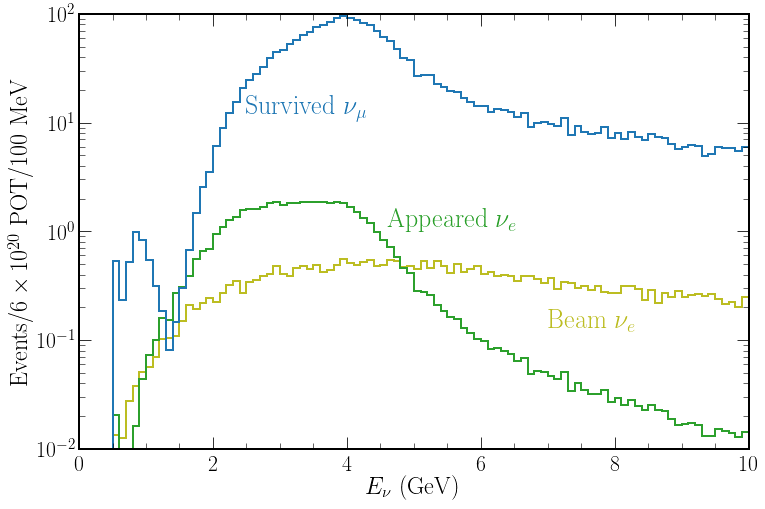

In [9]:
nuel_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 0) & 
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 0)
]
osc_nuel_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 0) & 
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 1)
]
numu_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 1) &
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 0)
]

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
axs.hist(nuel_ev["t_nu_energy"]/1000, weights=nuel_ev["w"], range=(0, 10), bins=100, color='tab:olive', histtype='step', linewidth=2)
axs.hist(osc_nuel_ev["t_nu_energy"]/1000, weights=osc_nuel_ev["w"], range=(0, 10), bins=100, color='tab:green', histtype='step', linewidth=2)
axs.hist(numu_ev["t_nu_energy"]/1000, weights=numu_ev["w"], range=(0, 10), bins=100, color='tab:blue', histtype='step', linewidth=2)
axs.text(2.5, 11, r"Survived $\nu_{\mu}$", color='tab:blue')
axs.text(4.6, 1, r"Appeared $\nu_{e}$", color='tab:green')
axs.text(7, 0.12, r"Beam $\nu_{e}$", color='tab:olive')
axs.set_yscale('log')
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/100 MeV", fontsize=24)
axs.set_ylim(10e-3, 10e1)
chipsnet.plotting.save(save_path + "explore_osc_fluxes")

In [10]:
def plot_training_sample(events, scale, save_name):
    data = [
        len(events[events["t_all_cat"] == i])
        for i in range(len(chipsnet.data.MAP_ALL_CAT["labels"]))
    ]
    data = [x * scale for x in data]

    labels = chipsnet.data.MAP_ALL_CAT["labels"]
    cats = np.arange(len(labels))
    width = 1

    fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
    axs.bar(cats, data, color="tab:blue", width=width, label="training sample", edgecolor='black')
    axs.set_xticks(cats)
    axs.set_xticklabels(labels, fontsize=18, rotation="vertical")
    axs.set_ylabel("Training events")
    axs.set_yscale('log')
    axs.set_ylim(10e2, 10e6)
    chipsnet.plotting.save(save_name)

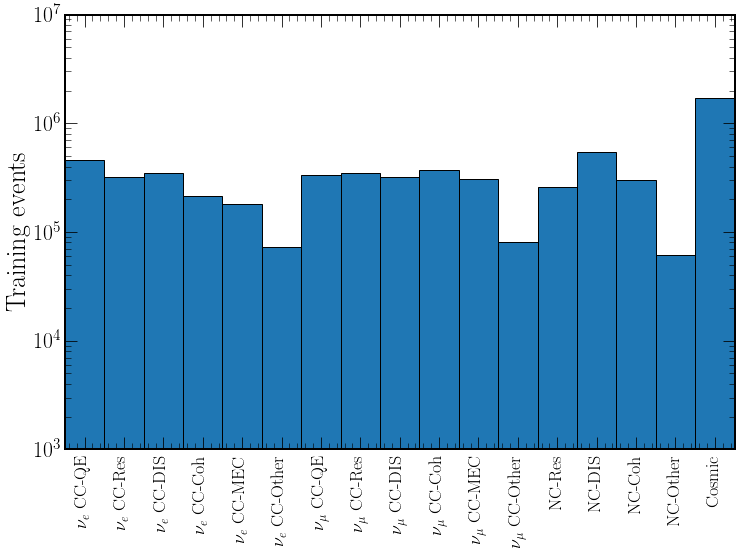

In [11]:
plot_training_sample(s_both_ev, (total_flux_events+total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "explore_both_sample")

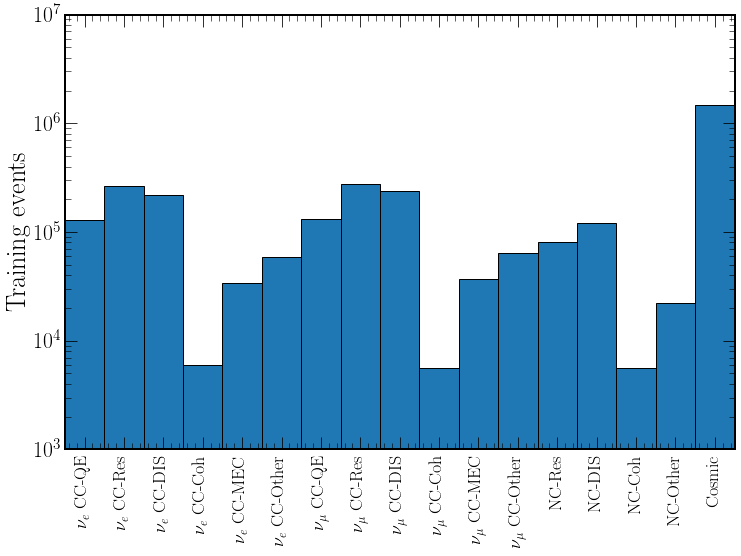

In [12]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, save_path + "explore_flux_sample")

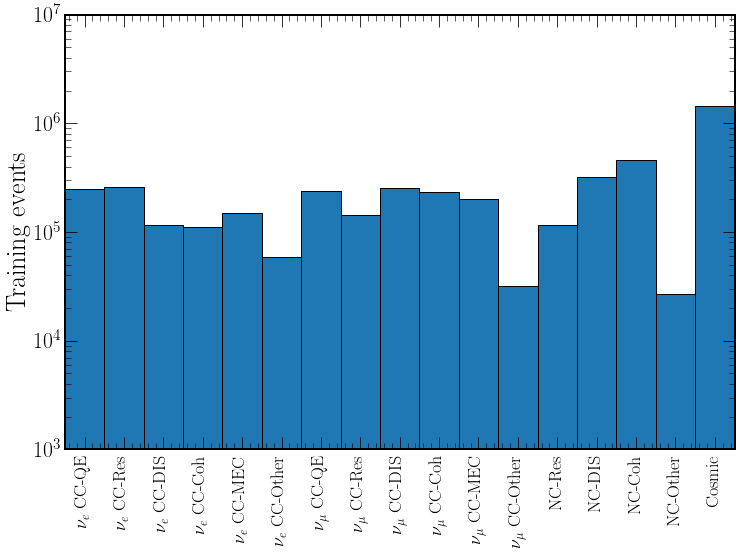

In [13]:
plot_training_sample(s_uniform_ev, (total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "explore_uniform_sample")

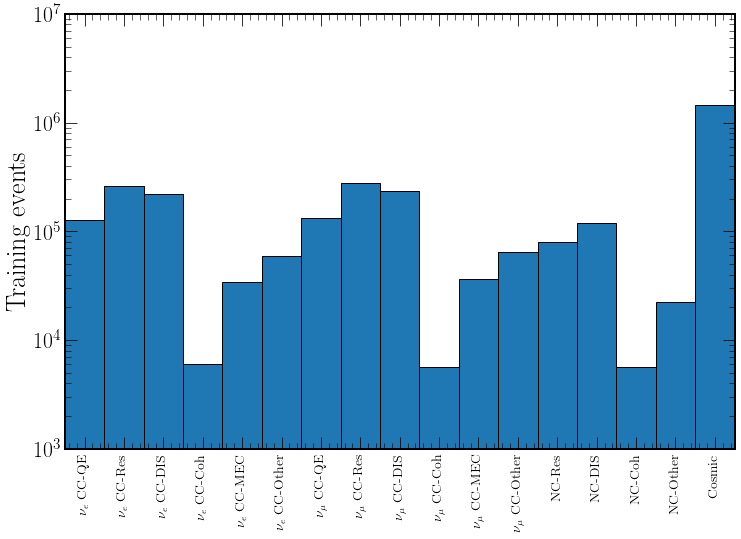

In [14]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_ALL_CAT, save_path)

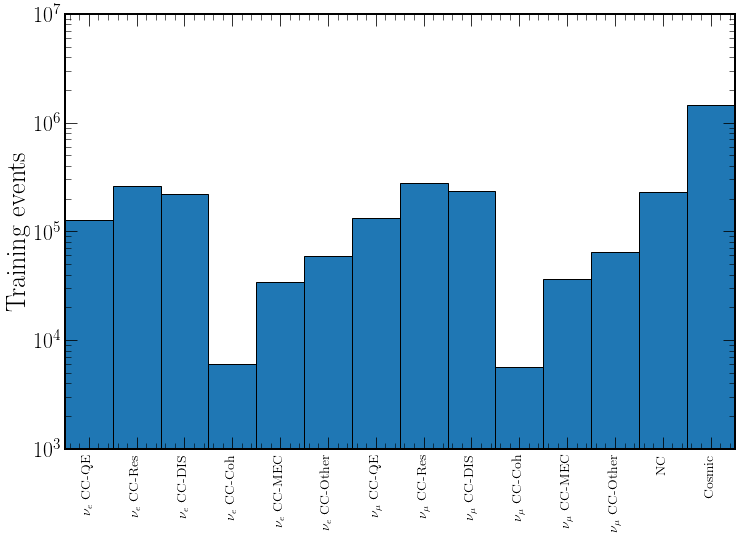

In [15]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_NC_COMB_CAT, save_path)

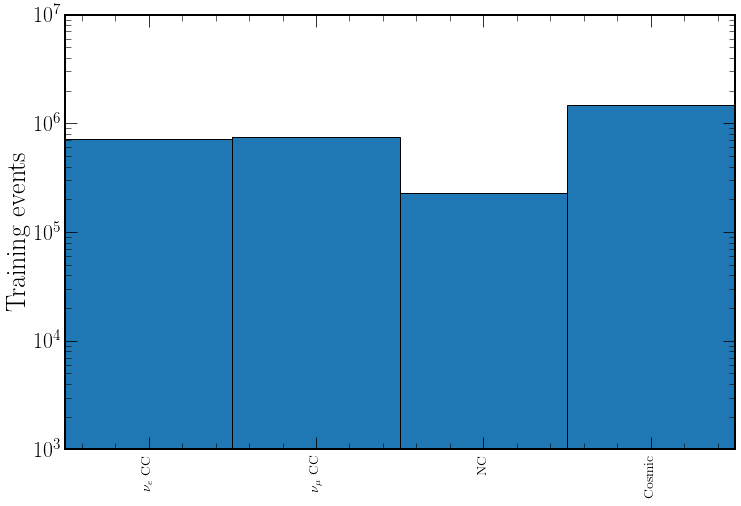

In [16]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

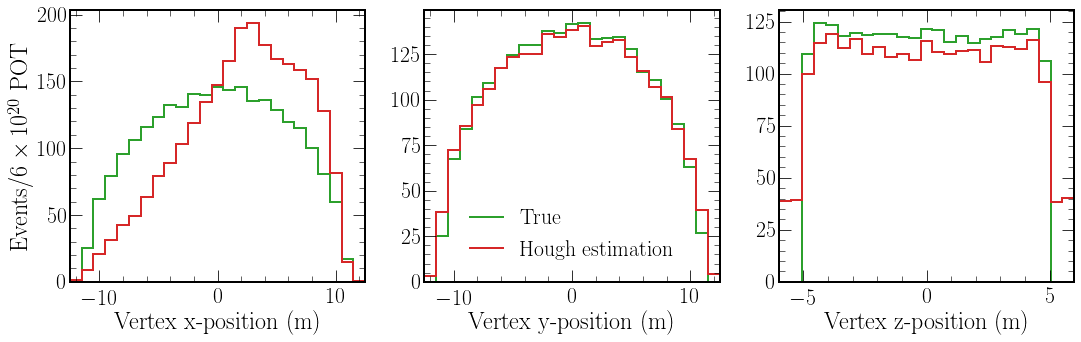

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100, 
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[0].set_xlabel('Vertex x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=24)
single = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label="True")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="Hough estimation")
axs[1].legend(handles=[single, multi], loc="lower center")

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100,
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[1].set_xlabel('Vertex y-position (m)', fontsize=24)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100,
            range=(-6, 6), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100, 
            range=(-6, 6), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[2].set_xlabel('Vertex z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "explore_vtx_positions")

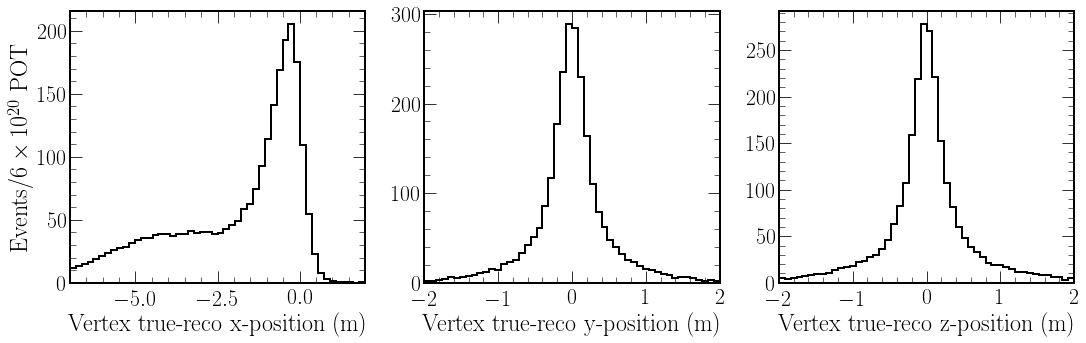

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-7, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=24)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=24)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100), 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "explore_true_reco_vtx")

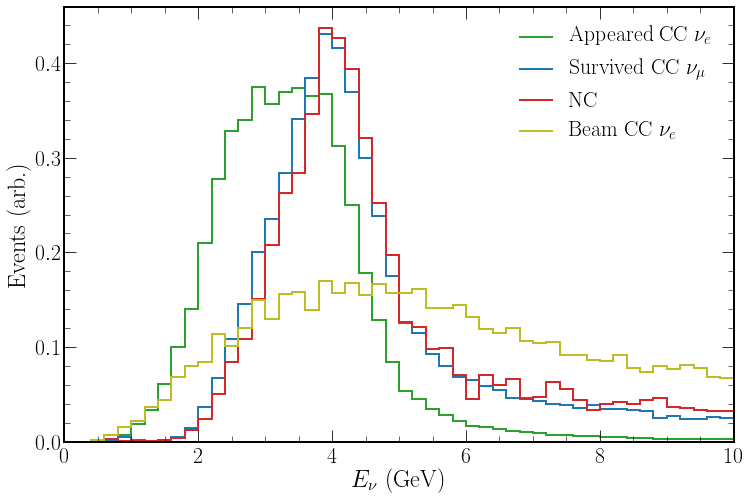

In [20]:
osc_nuel = matplotlib.lines.Line2D([], [], c='tab:green', linewidth=2)
numu = matplotlib.lines.Line2D([], [], c='tab:blue', linewidth=2)
nc = matplotlib.lines.Line2D([], [], c='tab:red', linewidth=2)
nuel = matplotlib.lines.Line2D([], [], c='tab:olive', linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["w"],
         range=(0, 10), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=50, color='tab:blue', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["w"],
         range=(0, 10), bins=50, color='tab:olive', histtype='step', density=True, linewidth=2)
axs.legend(loc="upper right", handles=[osc_nuel, numu, nc, nuel], labels=[r"Appeared CC $\nu_{e}$", r"Survived CC $\nu_{\mu}$", r"NC", r"Beam CC $\nu_{e}$"])
axs.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=24)
axs.set_ylabel('Events (arb.)', fontsize=24)
#plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
chipsnet.plotting.save(save_path + "explore_nu_energies")

In [21]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
true_dict = {"t_code": [], "t_nu_energy": [], "t_lep_energy":[], "t_p_pdgs": [], "t_p_energies": [], "t_escapes": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))
for truth_info in true_dict.keys():
    true_dict[truth_info].extend(nuel_file['true'].array(truth_info))
    true_dict[truth_info].extend(numu_file['true'].array(truth_info))
    true_dict[truth_info].extend(cosmic_file['true'].array(truth_info))    

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4769380479133997


3
3307.41
2777.48
[  11 2212 2212  111 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2777.48  1085.32   991.703  318.527 -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


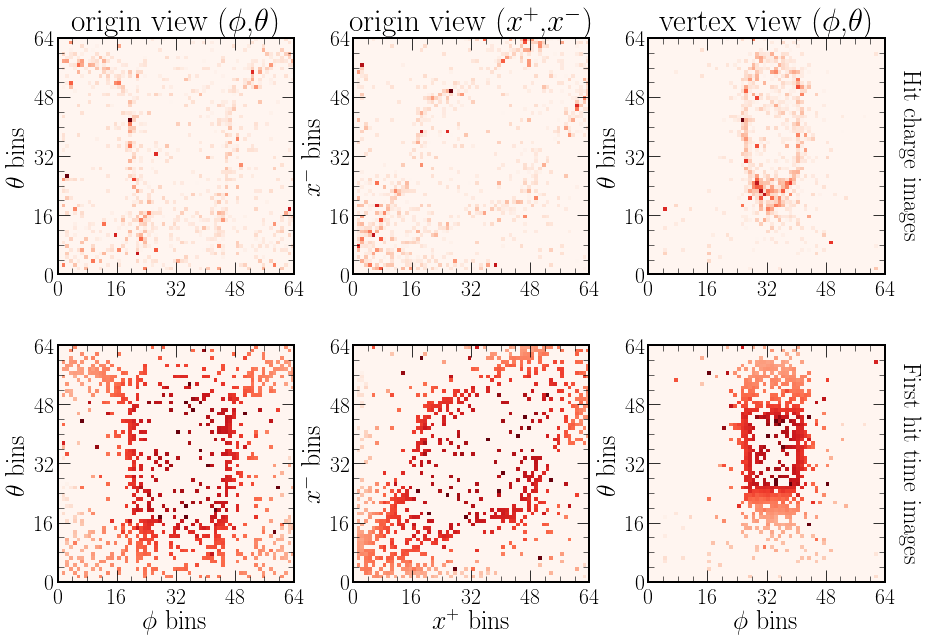

In [22]:
event_num = 1009
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_nuel_ccres_event")

91
3520.17
1862.55
[2212   13 2112  211  211   22 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2022.37  1862.55  1038.34   226.973  223.71     6.32  -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


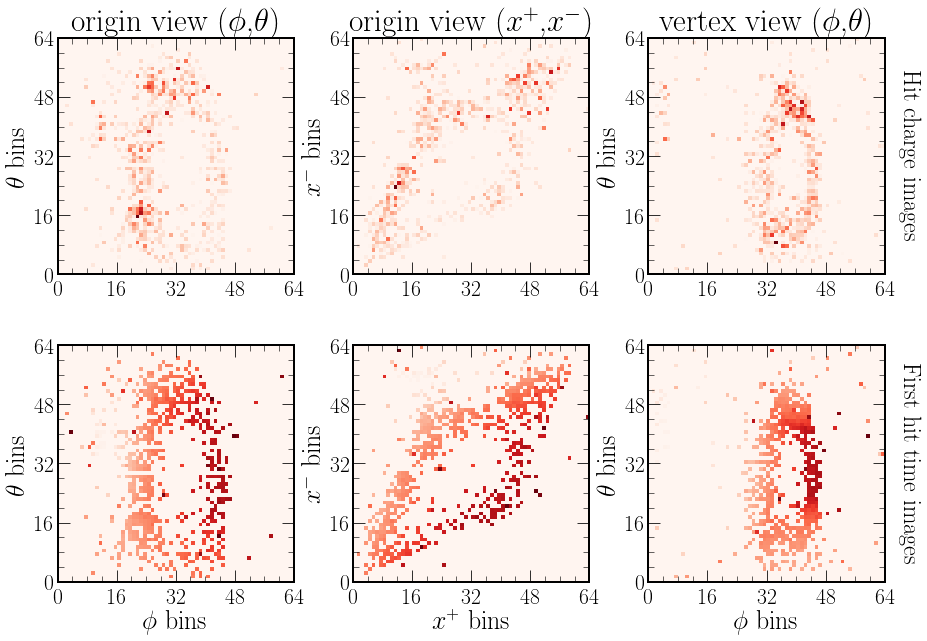

In [23]:
event_num = 2014

print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_numu_ccdis_event")

100
2928.5
2928.5
[  13 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2928.5 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.
 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999. ]
0


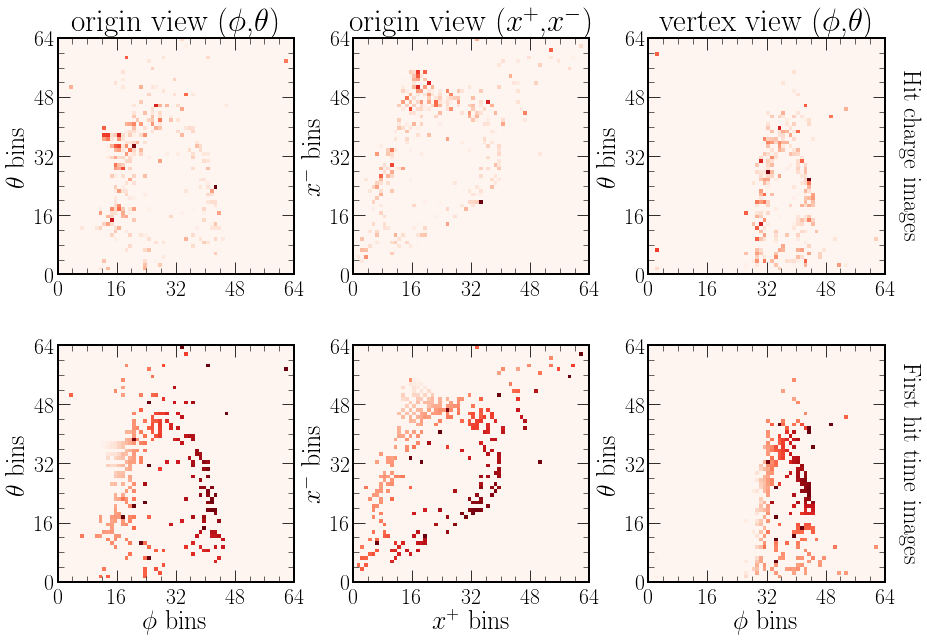

In [24]:
event_num = 4006
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_cosmic_event")

92
9301.59
-1.0
[  12 2212  211 2212 2212 2112 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[4731.25  2635.15  2511.54  1046.97   998.676  993.868 -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
-1


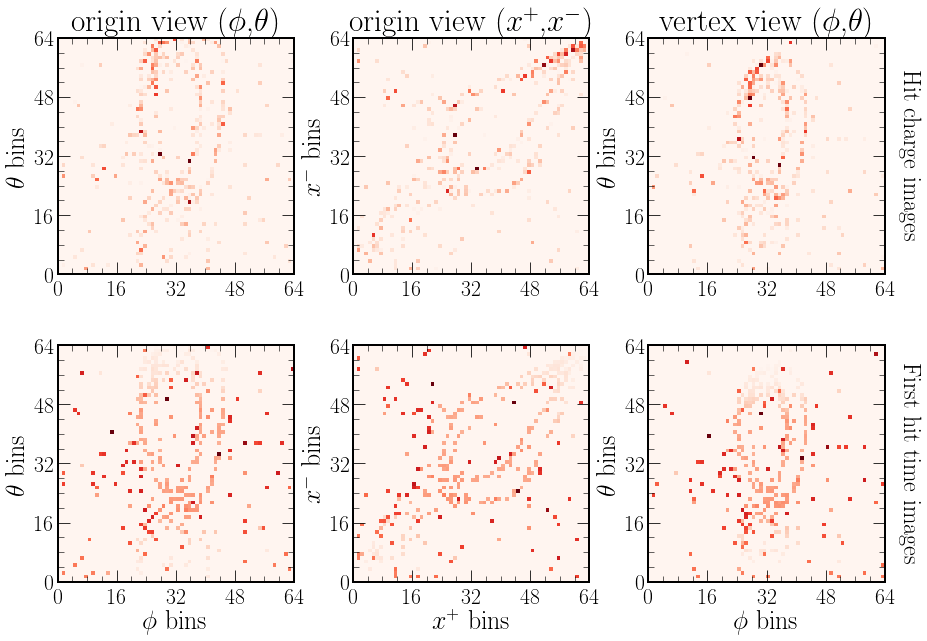

In [25]:
event_num = 1045
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_nuel_ncdis_event")

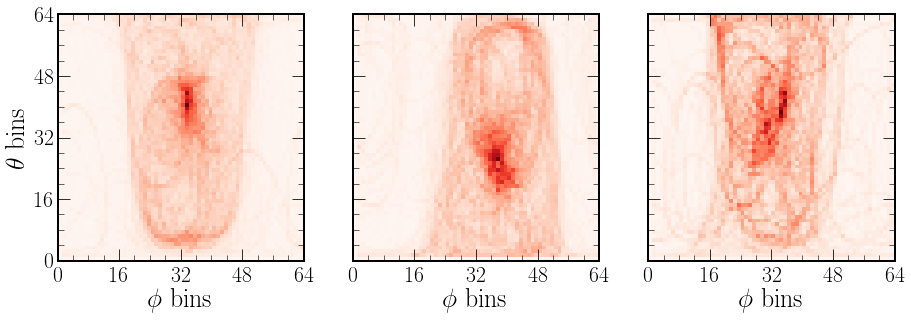

In [26]:
chipsnet.plotting.plot_hough(images_dict, [1009, 2014, 1045], save_path+"explore_hough_events")

[0,25], outside range: 0.0023
[0,120], outside range: 0.0023
[0,3500], outside range: 0.0023


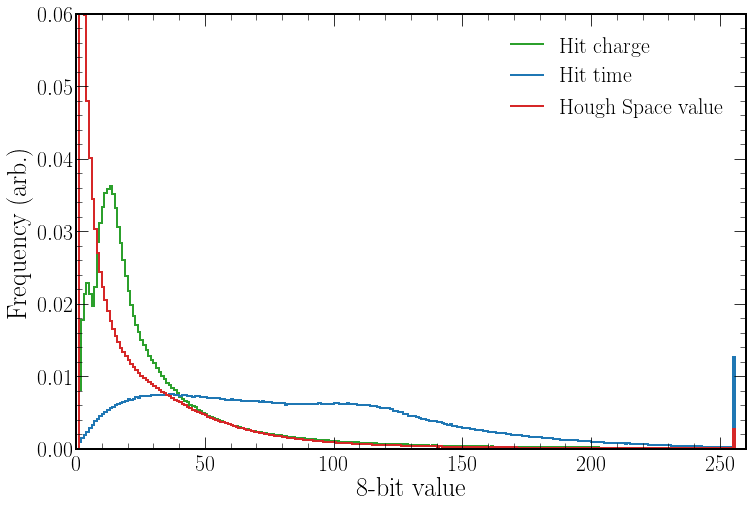

In [28]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

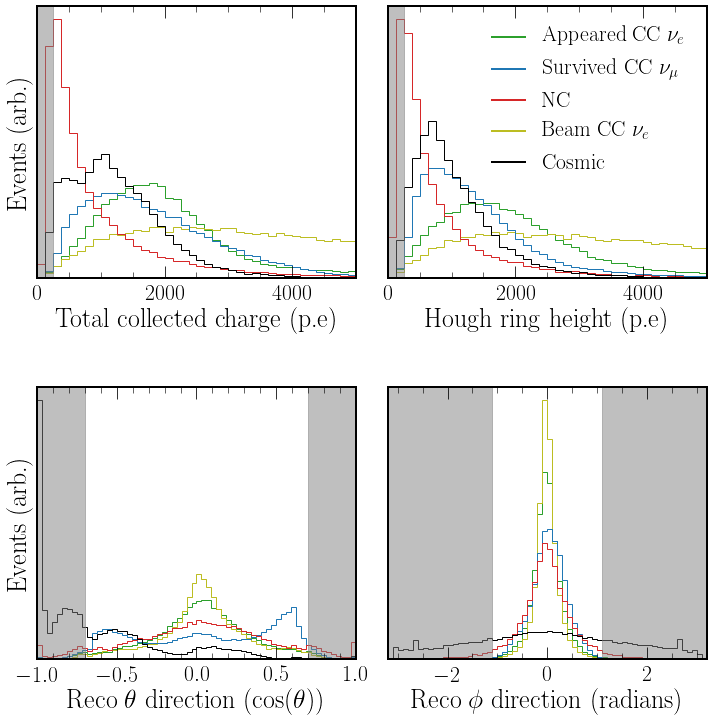

In [29]:
chipsnet.plotting.plot_cuts(config, flux_ev, save_path)

In [30]:
# Tidy up
del s_both_ev, s_both_out
del s_flux_ev, s_flux_out
del s_uniform_ev, s_uniform_out
del flux_ev, flux_out
del images_dict
del numu_ev, nuel_ev, osc_nuel_ev

<a id='sample'></a>

## Which training sample is best? (sample)
* The training sample used has a significant impact on performance.
* This is due to both the ratio of the different number of events and the energy distribution of them
* Using the expected beam flux as expected has the best performance for then evaluating the beam flux

In [4]:
ev, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_all_cat", "t_all_cat", "t_all_cat"]
)


************************ Evaluating flux ************************
Loading best checkpoint (7)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ sample_both report ------------------------
- Comb-> Prec: (0.93986,0.69923), Rec: (0.90418,0.86362), F1: (0.91708,0.73938)
- Cat->  Prec: (0.58622,0.33926), Rec: (0.49476,0.43358), F1: (0.50887,0.30760)

- Nuel-> ROC-AUC: 0.82063, PRC-AUC: 0.63426, S-Eff: 0.83421, S-Pur: 0.36814
- FOM1-> 0.38628, 0.84000, 52.60971, 19.59654, 18.26900, 0.66431, 0.58148
- FOM2-> 10.10769, 0.96000, 30.52599, 4.49055, 4.63030, 0.38545, 0.76995

- Numu-> ROC-AUC: 0.66439, PRC-AUC: 0.92134, S-Eff: 0.85414, S-Pur: 0.99374
- FOM1-> 0.87121, 0.10500, 4.15601, 1834.58254, 48.03648, 0.89600, 0.97234
- FOM2-> 2162.27798, 0.99500, 0.02434, 1409.09490, 0.40033, 0.68819, 0.99970


------------------------ sample_flux report ------------------------
- Comb-> Prec: (0.9447

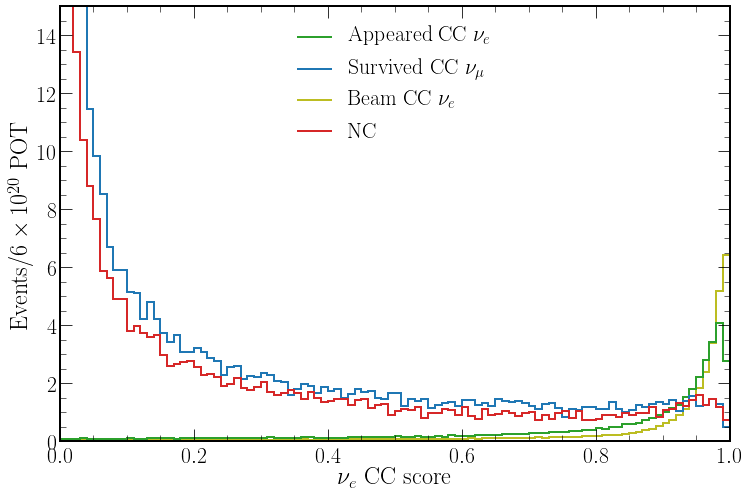

In [5]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_both_", save_path+"sample_both_output_values")

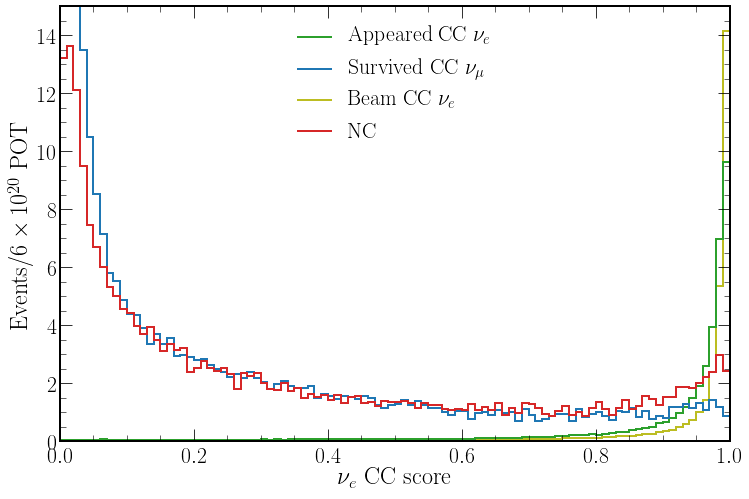

In [6]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_flux_", save_path+"sample_flux_output_values")

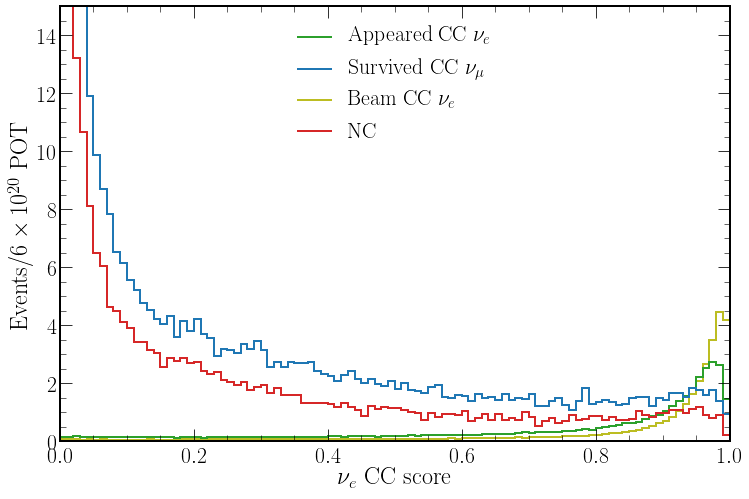

In [7]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_uniform_", save_path+"sample_uniform_output_values")

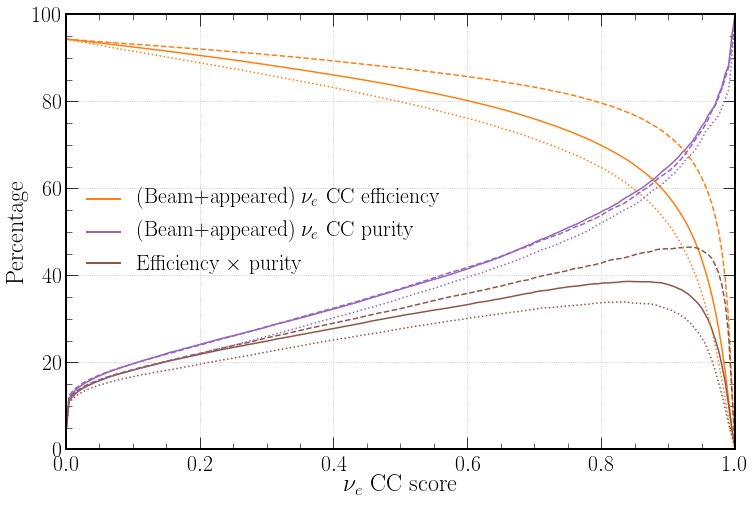

In [8]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_eff_curves")

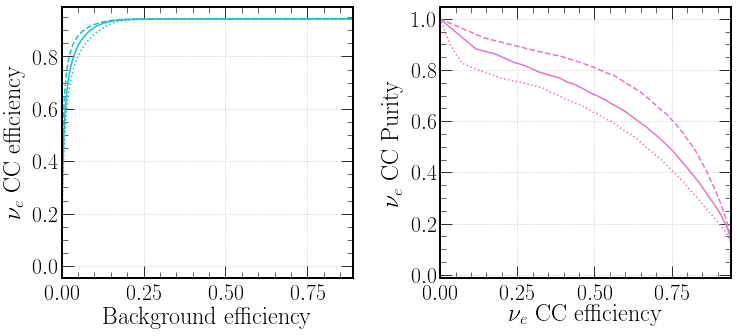

In [9]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_comp_curves")

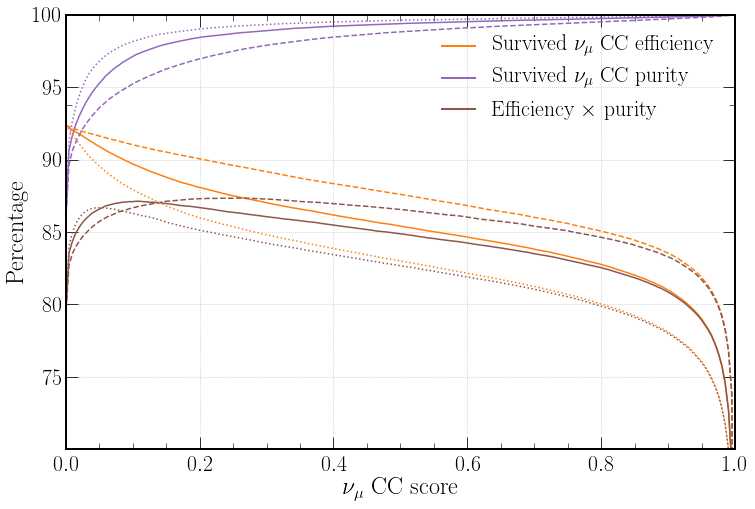

In [10]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_eff_curves")

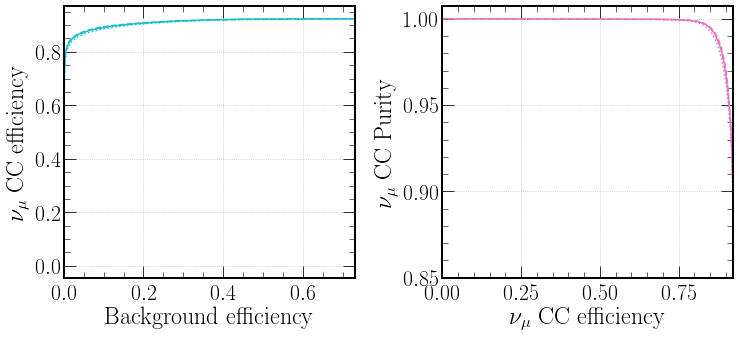

In [11]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_comp_curves")

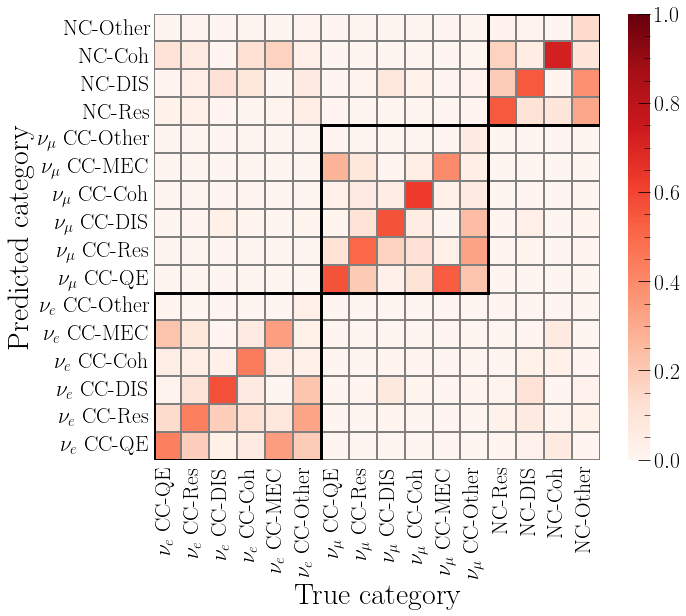

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[0]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_both_matrix")

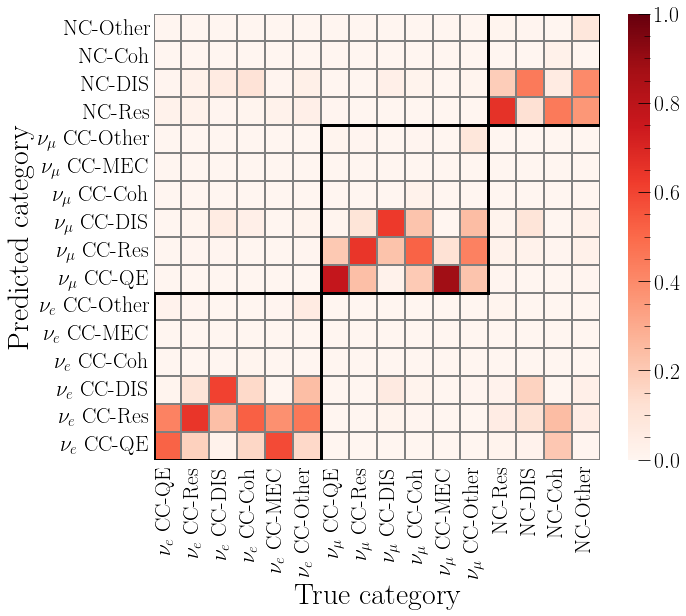

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[1]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_flux_matrix")

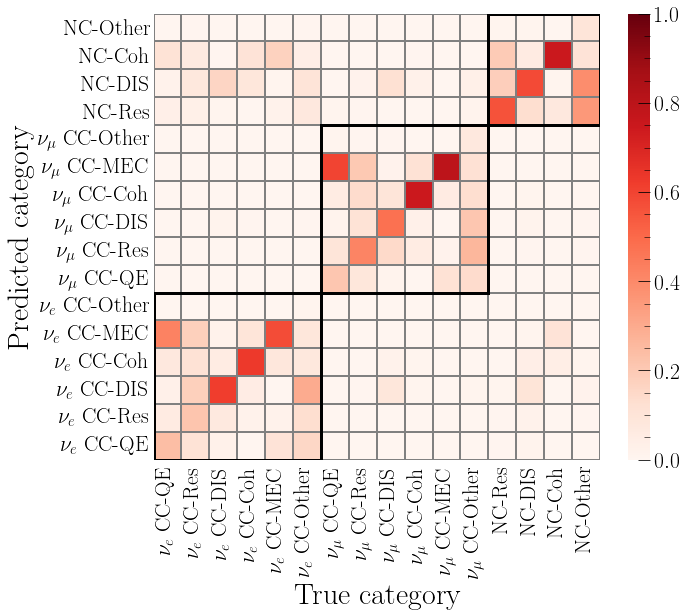

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[2]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_uniform_matrix")

In [15]:
# Tidy up
del outputs

<a id='repr'></a>

## Which image representation is best? (repr)
* The theta/phi representation as viewed from the roughly reconstructed interaction vertex is clearly the best
* It performs better on every performance metric
* This is definitely due to the way it standardises the input events, so they are scaled/viewed correctly and the different shapes can more easily be identified.

In [16]:
v_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Vertex theta/phi repr
o_out = chipsnet.utils.evaluate(config, "o_ct_flux", ["repr_o_ct"], ["t_all_cat"], just_out=True)  # Origin theta/phi repr
i_out = chipsnet.utils.evaluate(config, "i_ct_flux", ["repr_i_ct"], ["t_all_cat"], just_out=True)  # Origin x+/x- repr


************************ Evaluating v_ct_flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94500,0.71822), Rec: (0.90758,0.85195), F1: (0.91984,0.73189)
- Cat->  Prec: (0.58098,0.35860), Rec: (0.55899,0.32610), F1: (0.54125,0.27742)

- Nuel-> ROC-AUC: 0.82509, PRC-AUC: 0.70686, S-Eff: 0.87786, S-Pur: 0.35433
- FOM1-> 0.46118, 0.93000, 52.98765, 8.61419, 15.27335, 0.66908, 0.68927
- FOM2-> 13.26595, 0.98500, 29.74203, 1.43964, 3.58684, 0.37556, 0.85543

- Numu-> ROC-AUC: 0.66452, PRC-AUC: 0.92136, S-Eff: 0.87094, S-Pur: 0.98953
- FOM1-> 0.87258, 0.21500, 3.47311, 1832.94796, 44.05408, 0.89520, 0.97473
- FOM2-> 1808.09450, 0.99500, 0.02799, 1479.26387, 0.64136, 0.72246, 0.99955

took 494.80 seconds

************************ Evaluating o_ct_flux ************************
Loading best checkpoint (11)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501601,0.96051), (330186,0.93136), (102603,0.69676), (0,0.00000)

------------------------ repr_o_ct report ------------------------
- Comb-> Prec: (0.93958,0.68546), Rec: (0.88350,0.83975), F1: (0.90365,0.69786)
- Cat->  Prec: (0.56414,0.33570), Rec: (0.54305,0.32486), F1: (0.53148,0.26958)

- Nuel-> ROC-AUC: 0.82178, PRC-AUC: 0.67486, S-Eff: 0.87439, S-Pur: 0.29114
- FOM1-> 0.42202, 0.95500, 50.65626, 10.27209, 15.82963, 0.63948, 0.65995
- FOM2-> 12.53864, 0.99000, 29.40728, 1.75353, 3.74706, 0.37123, 0.84243

- Numu-> ROC-AUC: 0.66254, PRC-AUC: 0.92044, S-Eff: 0.84324, S-Pur: 0.99149
- FOM1-> 0.86222, 0.11500, 6.16222, 1839.28269, 68.00608, 0.89699, 0.96124
- FOM2-> 1719.81273, 0.99500, 0.04092, 1443.41013, 0.66348, 0.70393, 0.99951

took 728.63 seconds

************************ Evaluating i_ct_flux ************************
Loading best checkpoint (11)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501601,0.96051), (330186,0.93136), (102603,0.69676), (0,0.00000)

------------------------ repr_i_ct report ------------------------
- Comb-> Prec: (0.94022,0.69017), Rec: (0.88540,0.83618), F1: (0.90486,0.69869)
- Cat->  Prec: (0.56513,0.34174), Rec: (0.54376,0.32072), F1: (0.53127,0.26850)

- Nuel-> ROC-AUC: 0.82116, PRC-AUC: 0.66987, S-Eff: 0.86660, S-Pur: 0.29764
- FOM1-> 0.41895, 0.94500, 50.97483, 10.86474, 16.45768, 0.64350, 0.65104
- FOM2-> 12.22739, 0.99000, 28.43808, 1.74364, 3.66555, 0.35900, 0.84019

- Numu-> ROC-AUC: 0.66213, PRC-AUC: 0.92035, S-Eff: 0.84604, S-Pur: 0.99034
- FOM1-> 0.86023, 0.16000, 5.98145, 1833.79114, 66.68128, 0.89431, 0.96189
- FOM2-> 1932.24880, 0.99500, 0.03631, 1424.95396, 0.50753, 0.69493, 0.99962

took 499.12 seconds


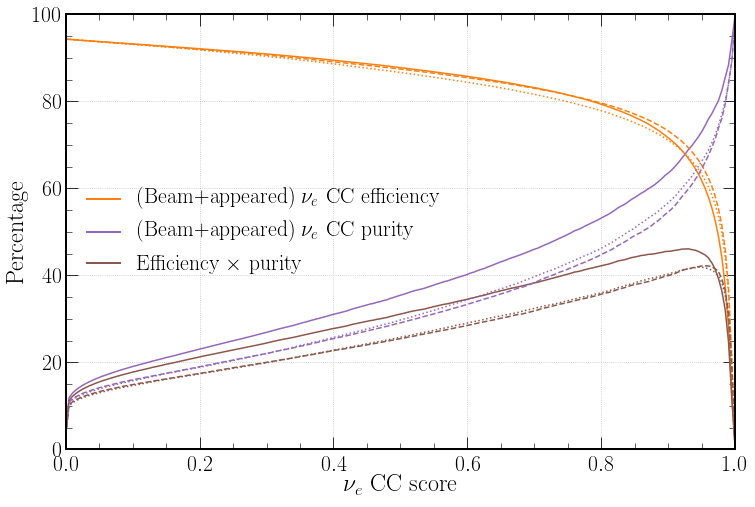

In [17]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_eff_curves")

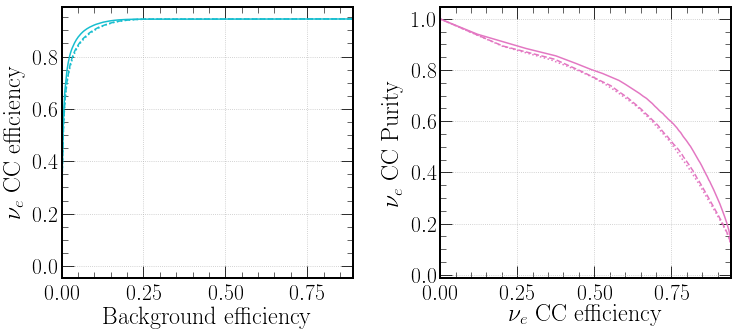

In [18]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_comp_curves")

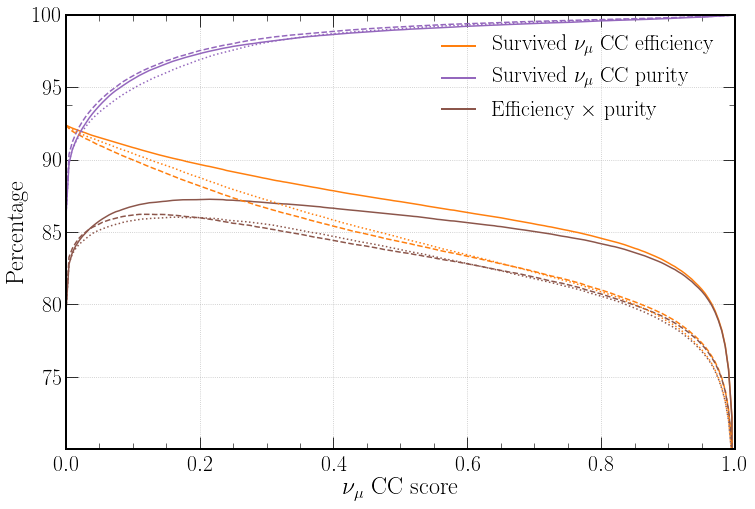

In [19]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_eff_curves")

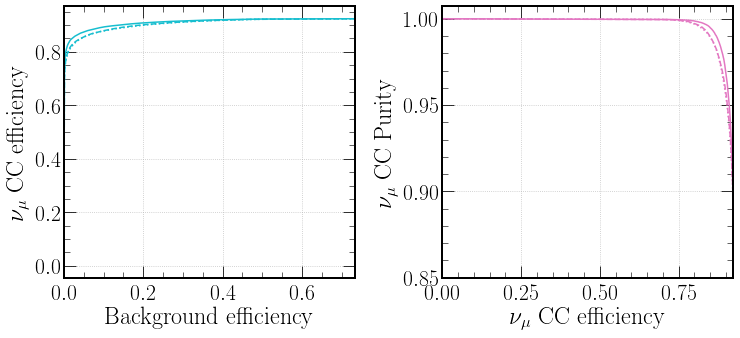

In [20]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_comp_curves")

In [21]:
# Tidy up
del v_out
del o_out
del i_out

<a id='arch'></a>

## Which network architecture works best?
* 1
* 2
* 3

In [ ]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["arch_vgg", "arch_inception", "arch_resnet", "arch_inception_resnet"],
    ["t_all_cat", "t_all_cat", "t_all_cat", "t_all_cat"],
    just_out=True
)

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"arch_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"arch_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"arch_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"arch_numu_comp_curves")

In [ ]:
# Tidy up
del outputs

<a id='channel'></a>

## Which channel configuration is best? (channel)
* The differences are much smaller than you would expect given the extra info you would think the extra channels provide
* Overall having all three channels together does make a difference
* It also is much better to have the seperate stems for each channel rather than using a single 3 channel image

In [22]:
c_out = chipsnet.utils.evaluate(config, "v_c_flux", ["repr_v_c"], ["t_all_cat"], just_out=True)  # Just charge channel
ct_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Charge+time channels
cth_out = chipsnet.utils.evaluate(config,"v_cth_flux", ["repr_v_cth"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels
cth_stacked_out = chipsnet.utils.evaluate(config, "v_cth_flux_stacked", ["repr_v_cth_stacked"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels stacked


************************ Evaluating v_c_flux ************************
Loading best checkpoint (7)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_c report ------------------------
- Comb-> Prec: (0.94303,0.71335), Rec: (0.90704,0.85438), F1: (0.91928,0.73424)
- Cat->  Prec: (0.57350,0.35225), Rec: (0.54850,0.31747), F1: (0.52990,0.27058)

- Nuel-> ROC-AUC: 0.82377, PRC-AUC: 0.68935, S-Eff: 0.86860, S-Pur: 0.35681
- FOM1-> 0.43601, 0.91000, 53.71070, 12.22704, 17.60798, 0.67821, 0.64289
- FOM2-> 12.70378, 0.99000, 20.73912, 0.76294, 1.90217, 0.26187, 0.88613

- Numu-> ROC-AUC: 0.66320, PRC-AUC: 0.92108, S-Eff: 0.86815, S-Pur: 0.98982
- FOM1-> 0.86819, 0.20500, 3.47107, 1825.07843, 45.22336, 0.89136, 0.97401
- FOM2-> 1781.71087, 0.99500, 0.05013, 1510.24116, 0.66836, 0.73759, 0.99952

took 469.76 seconds

************************ Evaluating v_ct_flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94500,0.71822), Rec: (0.90758,0.85195), F1: (0.91984,0.73189)
- Cat->  Prec: (0.58098,0.35860), Rec: (0.55899,0.32610), F1: (0.54125,0.27742)

- Nuel-> ROC-AUC: 0.82509, PRC-AUC: 0.70686, S-Eff: 0.87786, S-Pur: 0.35433
- FOM1-> 0.46118, 0.93000, 52.98765, 8.61419, 15.27335, 0.66908, 0.68927
- FOM2-> 13.26595, 0.98500, 29.74203, 1.43964, 3.58684, 0.37556, 0.85543

- Numu-> ROC-AUC: 0.66452, PRC-AUC: 0.92136, S-Eff: 0.87094, S-Pur: 0.98953
- FOM1-> 0.87258, 0.21500, 3.47311, 1832.94796, 44.05408, 0.89520, 0.97473
- FOM2-> 1808.09450, 0.99500, 0.02799, 1479.26387, 0.64136, 0.72246, 0.99955

took 495.46 seconds

************************ Evaluating v_cth_flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_cth report ------------------------
- Comb-> Prec: (0.94475,0.72485), Rec: (0.91102,0.85061), F1: (0.92158,0.73697)
- Cat->  Prec: (0.58293,0.37145), Rec: (0.56389,0.32640), F1: (0.54441,0.27883)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87661, S-Pur: 0.36928
- FOM1-> 0.46510, 0.93000, 53.44422, 8.34671, 15.75487, 0.67485, 0.68920
- FOM2-> 13.44645, 0.98500, 31.21664, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87599, S-Pur: 0.98808
- FOM1-> 0.87338, 0.25500, 3.22945, 1833.69924, 43.34847, 0.89557, 0.97523
- FOM2-> 1851.23532, 0.99500, 0.03552, 1509.65589, 0.62950, 0.73731, 0.99956

took 521.36 seconds

************************ Evaluating v_cth_flux_stacked ************************
Loading best checkpoint (9)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_cth_stacked report ------------------------
- Comb-> Prec: (0.94596,0.72742), Rec: (0.91607,0.86280), F1: (0.92596,0.75097)
- Cat->  Prec: (0.58565,0.36221), Rec: (0.56945,0.33514), F1: (0.55088,0.29113)

- Nuel-> ROC-AUC: 0.82521, PRC-AUC: 0.70198, S-Eff: 0.87180, S-Pur: 0.38254
- FOM1-> 0.45819, 0.91500, 55.18628, 11.56662, 17.17741, 0.69684, 0.65753
- FOM2-> 12.66558, 0.99000, 24.37959, 1.35104, 2.35408, 0.30784, 0.86807

- Numu-> ROC-AUC: 0.66522, PRC-AUC: 0.92153, S-Eff: 0.87580, S-Pur: 0.98999
- FOM1-> 0.87561, 0.21000, 3.17703, 1834.94072, 39.91363, 0.89617, 0.97706
- FOM2-> 1689.16620, 0.99500, 0.06176, 1540.32612, 0.76977, 0.75229, 0.99946

took 483.05 seconds


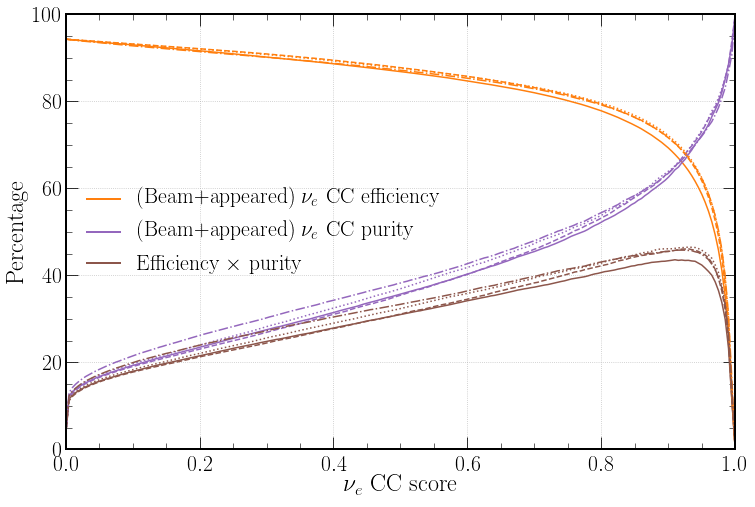

In [23]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_eff_curves")

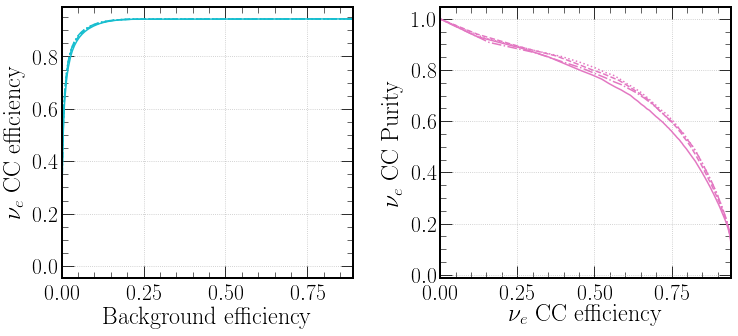

In [24]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_comp_curves")

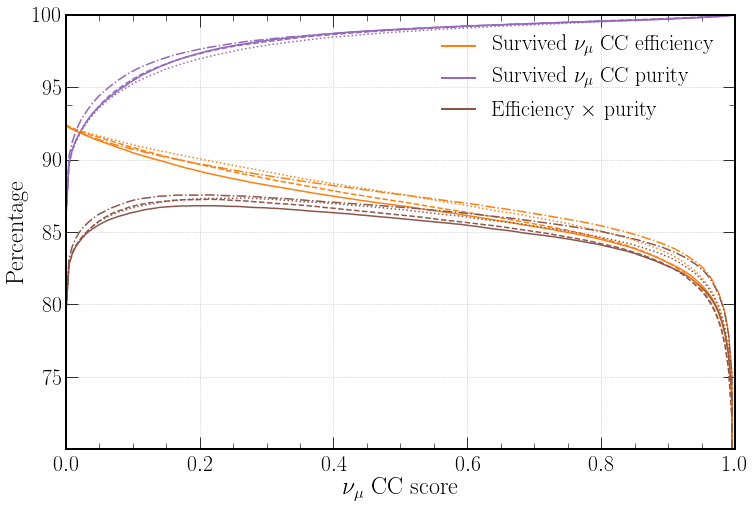

In [25]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_eff_curves")

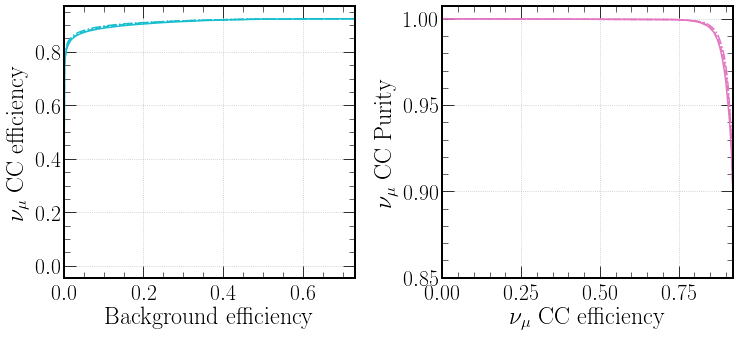

In [26]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_comp_curves")

In [27]:
# Tidy up
del c_out
del ct_out
del cth_out
del cth_stacked_out

<a id='cat'></a>

## Which categorisation is best? (cat)
* It looks like the split learner using ["t_comb_cat", "t_cc_type", "t_nc_type"] is the best, but by an almost negligble difference
* Still need to look at how well it splits apart to cc and nc types for full analysis
* A close second is then "t_all_cat" this is still reasonable to use to simplify other studies

In [28]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["cat_t_all_cat", "cat_t_nc_comb_cat", "cat_t_comb_cat", "cat_split", "cat_split_learn"], 
    ["t_all_cat", "t_nc_comb_cat", "t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (7)
Loading best checkpoint (5)
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ cat_t_all_cat report ------------------------
- Comb-> Prec: (0.94475,0.72485), Rec: (0.91102,0.85061), F1: (0.92158,0.73697)
- Cat->  Prec: (0.58293,0.37145), Rec: (0.56389,0.32640), F1: (0.54441,0.27883)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87661, S-Pur: 0.36928
- FOM1-> 0.46510, 0.93000, 53.44422, 8.34671, 15.75487, 0.67485, 0.68920
- FOM2-> 13.44645, 0.98500, 31.21664, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87599, S-Pur: 0.98808
- FOM1-> 0.87338, 0.25500, 3.22945, 1833.69924, 43.34847, 0.89557, 0.97523
- FOM2-> 1851.23532, 0.99500, 0.03552, 1509.65589, 0.62950, 0.73731, 0.99956


------------------------ cat_t_nc_

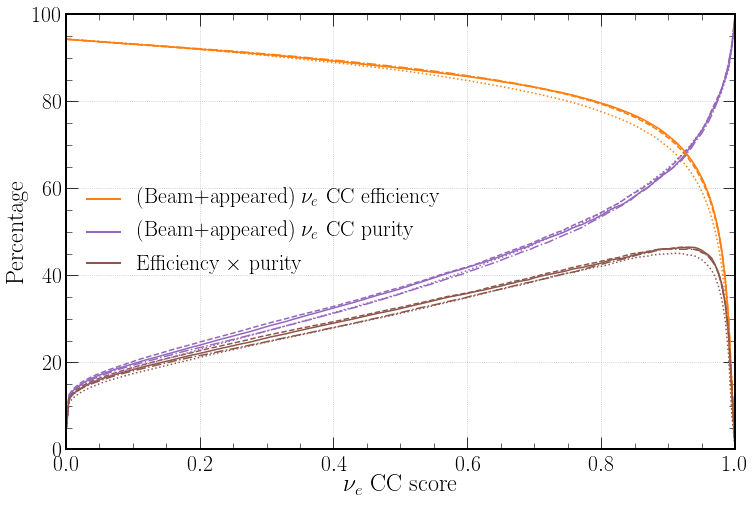

In [29]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_eff_curves")

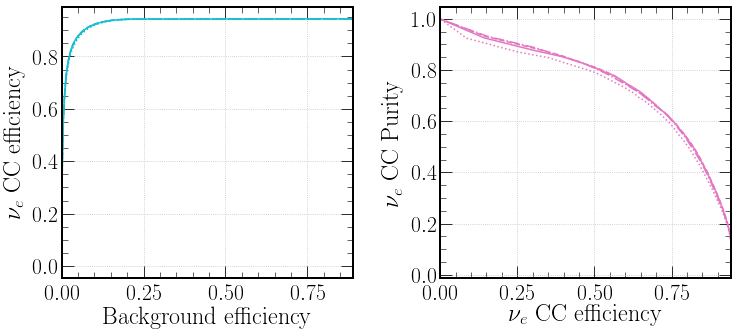

In [30]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_comp_curves")

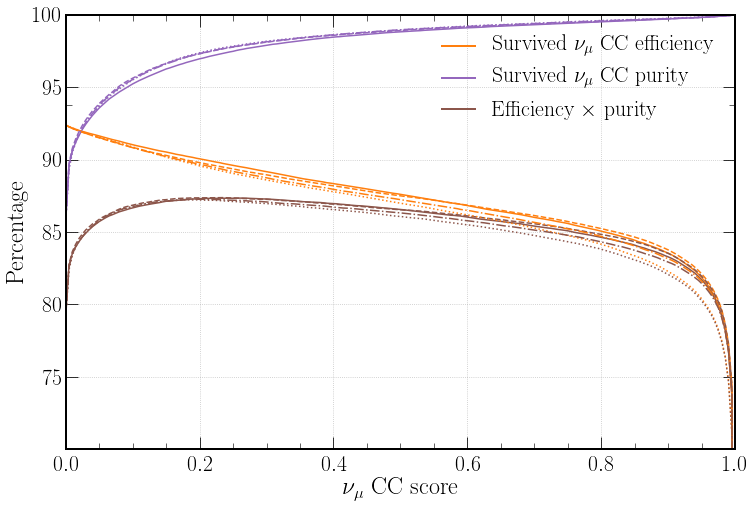

In [31]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_eff_curves")

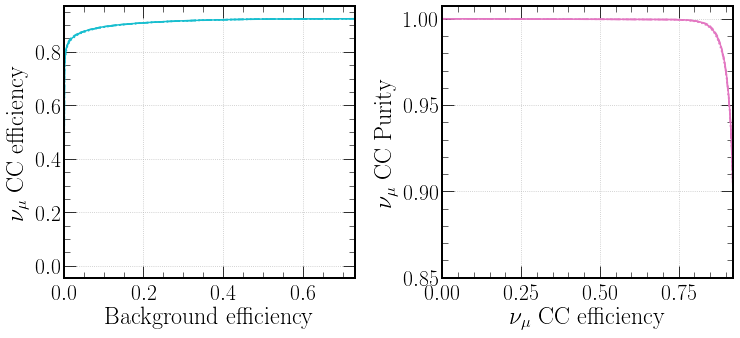

In [32]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_comp_curves")

In [33]:
# Tidy up
del outputs

<a id='cosmic'></a>

## Does escapes help cosmic classifier? (cosmic)
* Looks like the single t_cosmic_cat classifier and the learned + t_escapes are the best
* Looks like the events that do pass are mainly classified as NC which is good
* Need to do a final evaluation with the complete final beam model to make sure

In [34]:
ev, out = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_e, out_e = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_el, out_el = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes_learn"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)


************************ Evaluating cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (6)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,3.43199)
count    3.527680e+05
mean     9.992678e-01
std      1.917471e-02
min      2.661729e-10
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: cosmic_pred_t_cosmic_cat, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (6,0.00002)
took 213.13 seconds

************************ Evaluating cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (3)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,3.43199)
count    352768.000000
mean          0.998948
std           0.020130
min           0.000795
25%           0.999990
50%           0.999999
75%           1.000000
max           1.000000
Name: cosmic_escapes_pred_t_cosmic_cat, dtype: float64
count    263384.000000
mean          0.914934
std           0.091285
min           0.000227
25%           0.869715
50%           0.939248
75%           0.987616
max           0.999991
Name: cosmic_escapes_pred_t_escapes, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
took 217.03 seconds

************************ Evaluating cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (15)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,3.43199)
count    352768.000000
mean          0.999820
std           0.011252
min           0.000006
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: cosmic_escapes_learn_pred_t_cosmic_cat, dtype: float64
count    263384.000000
mean          0.922769
std           0.104116
min           0.000098
25%           0.888178
50%           0.962673
75%           0.994820
max           1.000000
Name: cosmic_escapes_learn_pred_t_escapes, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (3,0.00001)
took 216.06 seconds


In [35]:
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[1.60869889e-06 4.81871599e-02 7.38256821e-04 3.43030109e-03
 2.26554030e-06 1.62112589e-06]
[0.99998447 0.69523085 0.82561696 0.9636501  0.99992882 0.9999724 ]
[1.39880872e-05 2.56581931e-01 1.73644805e-01 3.29195743e-02
 6.89555268e-05 2.60208206e-05]
[1 1 1 1 1 1]


In [36]:
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[]
[]
[]
[]


In [37]:
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[1.60869889e-06 5.87562063e-04 1.76249437e-01]
[0.99998447 0.99702819 0.06851738]
[1.39880872e-05 2.38418037e-03 7.55233175e-01]
[1 1 2]


In [38]:
# Tidy up
del ev, out
del ev_e, out_e
del ev_el, out_el

<a id='beam'></a>

## Does primary count help beam classifier? (beam)
* Yes it does help, not a huge effect but it definitely add something, which makes sense.
* The "learned" version of the multitask weights seems to work best.
* Still need to combine with the correct category type to see if that has a different effect.

In [4]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (6)
Loading best checkpoint (4)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ beam report ------------------------
- Comb-> Prec: (0.94460,0.73392), Rec: (0.91711,0.85569), F1: (0.92553,0.75106)
- Cat->  Prec: (0.94460,0.73392), Rec: (0.91711,0.85569), F1: (0.92553,0.75106)

- Nuel-> ROC-AUC: 0.82578, PRC-AUC: 0.71645, S-Eff: 0.87190, S-Pur: 0.39323
- FOM1-> 0.47189, 0.92500, 54.78695, 9.24055, 16.29189, 0.69180, 0.68211
- FOM2-> 13.51890, 0.99000, 25.59982, 1.11573, 2.47011, 0.32325, 0.87714

- Numu-> ROC-AUC: 0.66495, PRC-AUC: 0.92146, S-Eff: 0.88081, S-Pur: 0.98647
- FOM1-> 0.87414, 0.21500, 3.82185, 1843.35250, 51.30760, 0.90028, 0.97096
- FOM2-> 1677.53044, 0.99500, 0.05181, 1534.41219, 0.78484, 0.74940, 0.99946


------------------------ beam_primaries report ------------------------
- Comb-> Prec: (0.94566,0.7

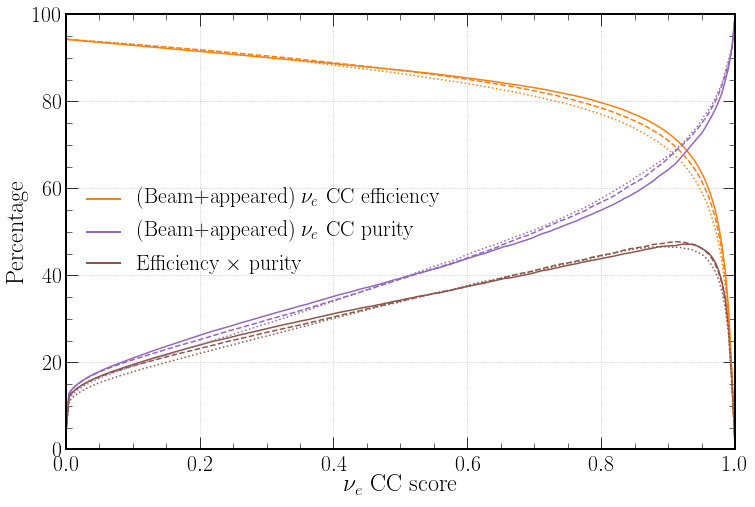

In [5]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_eff_curves")

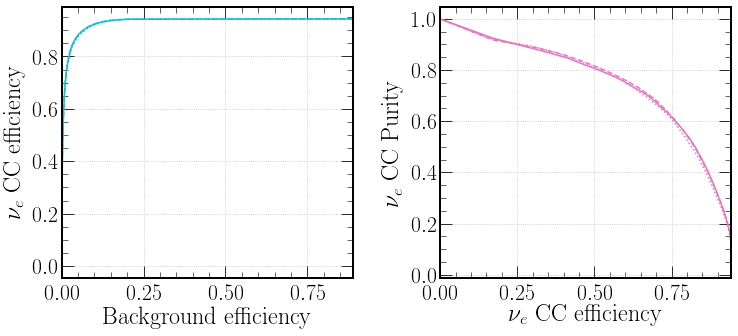

In [6]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_comp_curves")

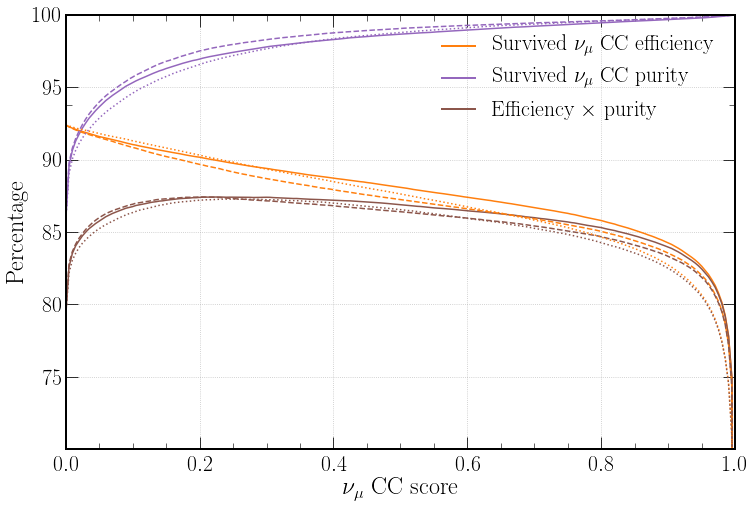

In [7]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_eff_curves")

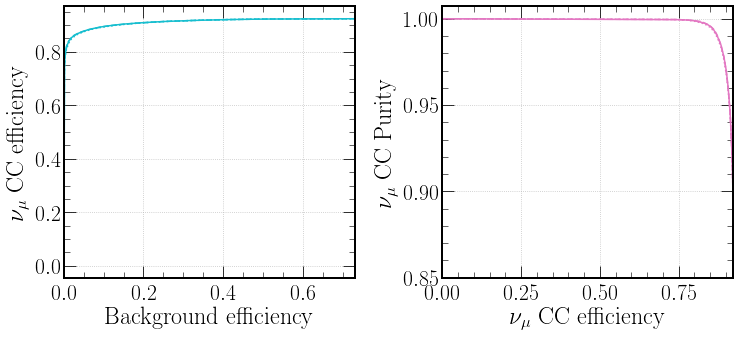

In [8]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_comp_curves")

In [9]:
# Tidy up
del outputs

<a id='energy_chan'></a>

## Does lepton energy help neutrino energy estimation? (energy_chan)
* There doesn't seem to be a noticable difference when both are trained together
* This has only been testing on nuel cc, it may be different for numu cc
* As its negligable we will train together using the learned approach as that seems best

In [10]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "nuel_all",
    ["energy_nu", "energy_lep", "energy_nu_lep", "energy_nu_lep_learn"],
    ["energy", "energy", "energy", "energy"]
)


************************ Evaluating nuel_all ************************
Loading best checkpoint (10)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (8)
Loading best checkpoint (10)
Loading best checkpoint (9)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
Cuts:    (165387,0.94681), (0,0.00000), (17587,0.66271), (0,0.00000)
took 144.28 seconds


In [11]:
ev = events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_lep_energy"] != -1)]

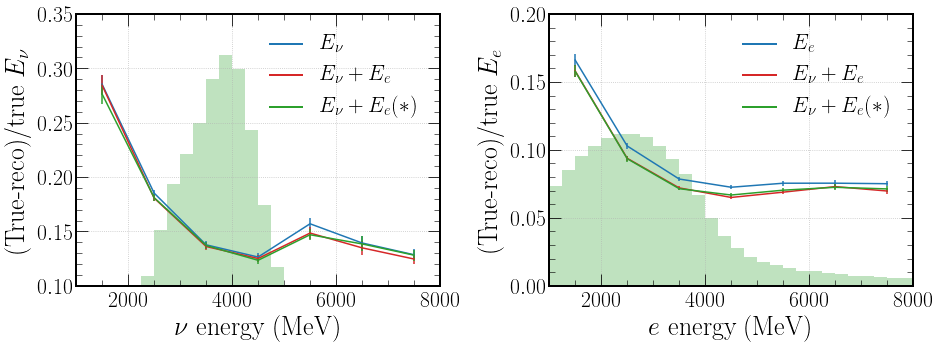

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.1, 0.35)
axs[0].set_xlim(1000, 8000)
axs[0].grid()
axs[0].hist(
    ev["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00002,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
axs[1].set(ylabel=r"(True-reco)/true $E_{e}$", xlabel=r"$e$ energy (MeV)")
axs[1].set_ylim(0.0, 0.2)
axs[1].set_xlim(1000, 8000)
axs[1].grid()
axs[1].hist(
    ev["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00001,
)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}$")
multi_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
axs[0].legend(handles=[nu, multi, multi_learn], loc="upper right")
axs[1].legend(handles=[lep, multi, multi_learn], loc="upper right")

chipsnet.plotting.save(save_path + "energy_chan_frac_vs_e")

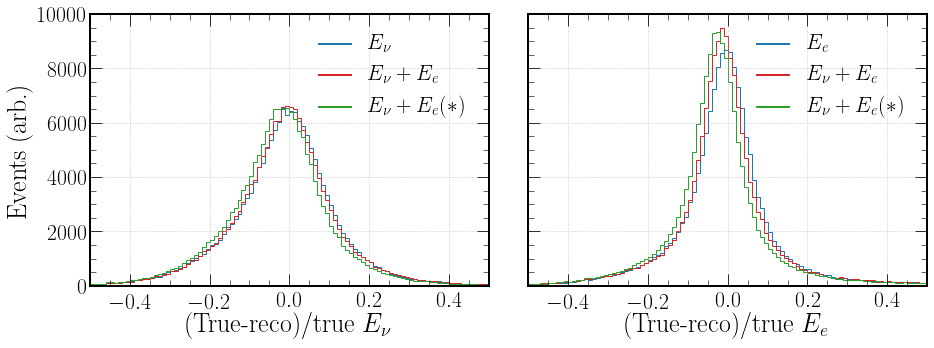

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    ev['energy_nu_frac_nu_energy'], 
    weights=ev["w"], 
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:blue"
)
axs[0].hist(
    ev['energy_nu_lep_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:red"
)
axs[0].hist(
    ev['energy_nu_lep_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[0].set(xlabel=r"(True-reco)/true $E_{\nu}$", ylabel=r"Events (arb.)")
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 10000)
axs[1].hist(
    ev['energy_lep_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:blue"
)
axs[1].hist(
    ev['energy_nu_lep_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:red"
)
axs[1].hist(
    ev['energy_nu_lep_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[1].set(xlabel=r"(True-reco)/true $E_{e}$")
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 10000)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}$")
multi_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
axs[0].legend(handles=[nu, multi, multi_learn], loc="upper right")
axs[1].legend(handles=[lep, multi, multi_learn], loc="upper right")

chipsnet.plotting.save(save_path + "energy_chan_frac_dist")

In [14]:
print(ev['energy_nu_frac_nu_energy'].describe())
print(ev['energy_nu_lep_frac_nu_energy'].describe())
print(ev['energy_nu_lep_learn_frac_nu_energy'].describe())

count    164530.000000
mean         -0.013350
std           0.144615
min          -0.815199
25%          -0.085478
50%          -0.007869
75%           0.061700
max           2.255519
Name: energy_nu_frac_nu_energy, dtype: float64
count    164530.000000
mean         -0.014822
std           0.144422
min          -0.821121
25%          -0.087244
50%          -0.010386
75%           0.058014
max           2.345950
Name: energy_nu_lep_frac_nu_energy, dtype: float64
count    164530.000000
mean         -0.029877
std           0.142873
min          -0.822591
25%          -0.101377
50%          -0.024325
75%           0.043181
max           2.074657
Name: energy_nu_lep_learn_frac_nu_energy, dtype: float64


In [15]:
print(ev['energy_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_learn_frac_lep_energy'].describe())

count    164530.000000
mean          0.095845
std           1.002137
min          -0.867242
25%          -0.059799
50%          -0.003821
75%           0.053585
max          86.890376
Name: energy_lep_frac_lep_energy, dtype: float64
count    164530.000000
mean          0.090190
std           1.000535
min          -0.885132
25%          -0.062734
50%          -0.011580
75%           0.044123
max          88.661810
Name: energy_nu_lep_frac_lep_energy, dtype: float64
count    164530.000000
mean          0.073290
std           0.981596
min          -0.887314
25%          -0.077853
50%          -0.025540
75%           0.028815
max          93.567320
Name: energy_nu_lep_learn_frac_lep_energy, dtype: float64


In [16]:
# Tidy up
del events, outputs, ev

<a id='energy_par'></a>

## Does vertex/escapes energy help neutrino energy estimation? (energy_par)
* Adding the vtx (learned) looks like the best
* The differences are all very small
* As we have escapes in cosmic rejection having vtx here would be good

In [17]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "nuel_all",
    ["energy_nu_lep_learn", "energy_nu_lep_vtx", "energy_nu_lep_vtx_learn", "energy_nu_lep_escapes", "energy_nu_lep_escapes_learn", "energy_nu_lep_vtx_escapes"],
    ["energy", "energy", "energy", "energy", "energy", "energy"]
)


************************ Evaluating nuel_all ************************
Loading best checkpoint (9)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (9)
Loading best checkpoint (8)
Loading best checkpoint (9)
Loading best checkpoint (12)
Loading best checkpoint (10)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
count    386.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: energy_nu_lep_escapes_pred_t_escapes, dtype: float64
count    386.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: energy_nu_lep_escapes_learn_pred_t_escapes, dtype: float64
count    386.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: energy_nu_lep_vtx_escapes_pred_t_escapes, dtype: float64
Cuts:    (165387,0.94681), (0,0.00000), (17587,0.66271), (0,0.00000)
took 213.93 seconds


In [18]:
ev = events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_lep_energy"] != -1)]

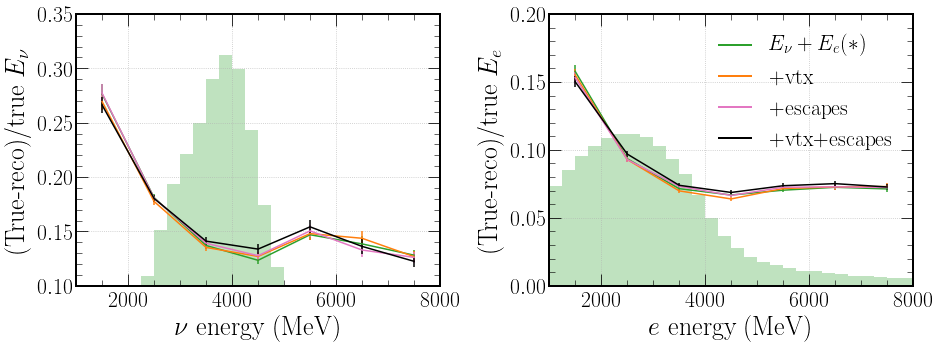

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_escapes_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:pink")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_escapes_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="black")
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.1, 0.35)
axs[0].grid()
axs[0].hist(
    ev["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00002,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_escapes_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:pink")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_escapes_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="black")
axs[1].set(ylabel=r"(True-reco)/true $E_{e}$", xlabel=r"$e$ energy (MeV)")
axs[1].set_ylim(0.0, 0.2)
axs[1].grid()
axs[1].hist(
    ev["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00001,
)

nu_lep = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="+vtx")
escapes_learn = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="+escapes")
both = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label="+vtx+escapes")
axs[1].legend(handles=[nu_lep, vtx_learn, escapes_learn, both], loc="upper right")

chipsnet.plotting.save(save_path + "energy_par_frac_vs_e")

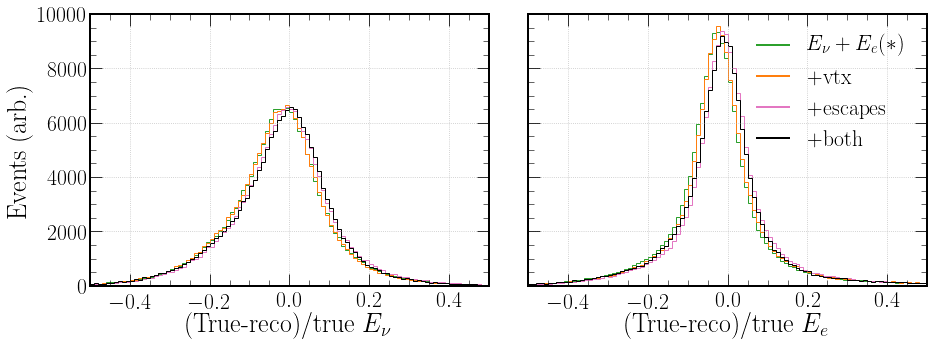

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    ev['energy_nu_lep_learn_frac_nu_energy'], 
    weights=ev["w"], 
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[0].hist(
    ev['energy_nu_lep_vtx_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:orange"
)
axs[0].hist(
    ev['energy_nu_lep_escapes_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:pink"
)
axs[0].hist(
    ev['energy_nu_lep_vtx_escapes_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="black"
)
axs[0].set(xlabel=r"(True-reco)/true $E_{\nu}$", ylabel=r"Events (arb.)")
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 10000)
axs[1].hist(
    ev['energy_nu_lep_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[1].hist(
    ev['energy_nu_lep_vtx_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:orange"
)
axs[1].hist(
    ev['energy_nu_lep_escapes_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:pink"
)
axs[1].hist(
    ev['energy_nu_lep_vtx_escapes_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="black"
)
axs[1].set(xlabel=r"(True-reco)/true $E_{e}$")
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 10000)
nu_lep = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="+vtx")
escapes_learn = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="+escapes")
both = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label="+both")
axs[1].legend(handles=[nu_lep, vtx_learn, escapes_learn, both], loc="upper right")
chipsnet.plotting.save(save_path + "energy_par_frac_dist")

In [21]:
print(ev['energy_nu_lep_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_escapes_frac_nu_energy'].describe())
print(ev['energy_nu_lep_escapes_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_escapes_frac_nu_energy'].describe())

count    164530.000000
mean         -0.029877
std           0.142873
min          -0.822591
25%          -0.101377
50%          -0.024325
75%           0.043181
max           2.074657
Name: energy_nu_lep_learn_frac_nu_energy, dtype: float64
count    164530.000000
mean         -0.018762
std           0.142929
min          -0.793584
25%          -0.090410
50%          -0.011781
75%           0.055334
max           2.141751
Name: energy_nu_lep_vtx_frac_nu_energy, dtype: float64
count    164530.000000
mean         -0.030745
std           0.142229
min          -0.798426
25%          -0.102166
50%          -0.024393
75%           0.042391
max           2.380956
Name: energy_nu_lep_vtx_learn_frac_nu_energy, dtype: float64
count    164530.000000
mean         -0.018812
std           0.143899
min          -0.818869
25%          -0.090578
50%          -0.013756
75%           0.054626
max           2.579321
Name: energy_nu_lep_escapes_frac_nu_energy, dtype: float64
count    164530.000000
mean     

In [22]:
print(ev['energy_nu_lep_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_escapes_frac_lep_energy'].describe())
print(ev['energy_nu_lep_escapes_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_escapes_frac_lep_energy'].describe())

count    164530.000000
mean          0.073290
std           0.981596
min          -0.887314
25%          -0.077853
50%          -0.025540
75%           0.028815
max          93.567320
Name: energy_nu_lep_learn_frac_lep_energy, dtype: float64
count    164530.000000
mean          0.092741
std           1.001716
min          -0.889168
25%          -0.067742
50%          -0.015463
75%           0.040333
max          81.644207
Name: energy_nu_lep_vtx_frac_lep_energy, dtype: float64
count    164530.000000
mean          0.088866
std           1.015930
min          -0.861897
25%          -0.070503
50%          -0.020454
75%           0.036229
max          86.140924
Name: energy_nu_lep_vtx_learn_frac_lep_energy, dtype: float64
count    164530.000000
mean          0.088680
std           1.003876
min          -0.866151
25%          -0.067975
50%          -0.015799
75%           0.041313
max          97.927773
Name: energy_nu_lep_escapes_frac_lep_energy, dtype: float64
count    164530.000000
mean 

In [23]:
# Tidy up
del events, outputs, ev

In [ ]:
ev_s = nuel_ccqel_ev[(nuel_ccqel_ev["cut"] == 0) & (nuel_ccqel_ev["t_all_cat"] == 0) & (nuel_ccqel_ev["t_lep_energy"] != -1)]
ev_f = flux_ev[(flux_ev["cut"] == 0) & (flux_ev["t_all_cat"] == 0) & (flux_ev["t_lep_energy"] != -1)]

fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_s, fit_name="final_nuel_ccqel_e_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_f, fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.0, 0.18)
axs[0].grid()
axs[0].hist(
    ev_f["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev_f["w"] * 0.05,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_s, fit_name="final_nuel_ccqel_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_f, fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
axs[1].set(ylabel=r"(True-reco)/true $E_{e}$", xlabel=r"$e$ energy (MeV)")
axs[1].set_ylim(0.0, 0.18)
axs[1].grid()
axs[1].hist(
    ev_f["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev_f["w"] * 0.05,
)

seperate = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"Seperate")
combined = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="Combined")
axs[1].legend(handles=[seperate, combined], loc="upper right")

chipsnet.plotting.save(save_path + "energy_split_frac_vs_e")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_pred_t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[0].set(xlabel=r"$\nu$ energy (MeV)", ylabel=r"Events/$6\times10^{20}$ POT/250 MeV")
axs[0].label_outer()
axs[0].set_ylim(0, 10)
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_pred_t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[1].set(xlabel=r"lepton energy (MeV)")
axs[1].label_outer()
axs[1].set_ylim(0, 10)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="upper right")
chipsnet.plotting.save(save_path + "energy_split_dists")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(4, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0, 0].hist2d(nuel_cccoh_ev["t_nu_energy"], nuel_cccoh_ev["final_nuel_cccoh_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"Reco energy (MeV)")
axs[0, 0].set_title(r"nuel")
axs[1, 0].hist2d(nuel_ccdis_ev["t_nu_energy"], nuel_ccdis_ev["final_nuel_ccdis_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"Reco energy (MeV)")
axs[2, 0].hist2d(nuel_ccqel_ev["t_nu_energy"], nuel_ccqel_ev["final_nuel_ccqel_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"Reco energy (MeV)")
axs[3, 0].hist2d(nuel_ccres_ev["t_nu_energy"], nuel_ccres_ev["final_nuel_ccres_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 0].grid()
axs[3, 0].label_outer()
axs[3, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0, 1].hist2d(numu_cccoh_ev["t_nu_energy"], numu_cccoh_ev["final_numu_cccoh_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 2250, "CC-COH", rotation=-90)
axs[1, 1].hist2d(numu_ccdis_ev["t_nu_energy"], numu_ccdis_ev["final_numu_ccdis_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8000, 2250, "CC-DIS", rotation=-90)
axs[2, 1].hist2d(numu_ccqel_ev["t_nu_energy"], numu_ccqel_ev["final_numu_ccqel_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8000, 2250, "CC-QEL", rotation=-90)
axs[3, 1].hist2d(numu_ccres_ev["t_nu_energy"], numu_ccres_ev["final_numu_ccres_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 1].grid()
axs[3, 1].label_outer()
axs[3, 1].text(8000, 2250, "CC-RES", rotation=-90)
axs[3, 1].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_cc")

In [ ]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0].hist2d(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 0]["final_nuel_cc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"Nuel CC")
axs[1].hist2d(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 1]["final_numu_cc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"Numu CC")
axs[2].hist2d(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 2]["final_nc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"NC")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)
* 1
* 2
* 3
* 4
* 5

In [24]:
# Run analysis through all the final models
events, outputs = chipsnet.utils.evaluate(
    config, "flux_cosmic", 
    ["final_cosmic", "final_beam", "final_nuel_cc_e", "final_numu_cc_e",
     "final_nuel_cccoh_e", "final_nuel_ccdis_e", "final_nuel_ccqel_e", "final_nuel_ccres_e",
     "final_numu_cccoh_e", "final_numu_ccdis_e", "final_numu_ccqel_e", "final_numu_ccres_e"],
    ["t_cosmic_cat", "t_comb_cat", "energy", "energy",
     "energy", "energy", "energy", "energy",
     "energy", "energy", "energy", "energy"]
)

# Seperate and print beam nuel vs oscillated nuel
print(events[(events["cut"]==0) & (events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0])]["w"].sum())
print(events[(events["cut"]==0) & (events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0])]["w"].sum())

# Get events run through old reco/pid for comparisons
old_events = pd.concat([
    chipsnet.utils.get_old_df(old_nuel_file, 11),
    chipsnet.utils.get_old_df(old_numu_file, 13)
])
old_events = chipsnet.utils.apply_weights(old_events, verbose=True)


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (7)
Loading best checkpoint (14)
Loading best checkpoint (4)
Loading best checkpoint (10)
Loading best checkpoint (13)
Loading best checkpoint (17)
Loading best checkpoint (18)
Loading best checkpoint (10)
Loading best checkpoint (8)
Loading best checkpoint (17)
Loading best checkpoint (12)
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,4.75840)
count    254434.000000
mean          0.999385
std           0.015476
min           0.001741
25%           0.999992
50%           0.999999
75%           1.000000
max           1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
count    340526.000000
mean          0.937040
std           0.138826
min           0.000002
25%           0.947088
50%           0.991456
75%           0.999034
max           1.000000
Name: final_cosmic_pred_t_escapes, dtype: float64
Cuts:    (391949,0.94955), (87336,0.35628), (75586,0.67693), (0,0.00000)

------------------------ final_beam repor

In [16]:
# Apply some standard operations we need throughout this section
def nuel_selected(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]:
        return True
    else:
        return False
    
def numu_selected(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_1"] >= outputs[0]["max_fom_cuts_0"][1]:
        return True
    else:
        return False
    
def nc_selected(event):
    if event["cosmic_cut"] == 0 and event["escapes_cut"] == 0 and not event["nuel_selected"] and not event["numu_selected"]:
        return True
    else:
        return False

events["nuel_selected"] = events.apply(nuel_selected, axis=1)
events["numu_selected"] = events.apply(numu_selected, axis=1)
events["nc_selected"] = events.apply(nc_selected, axis=1)

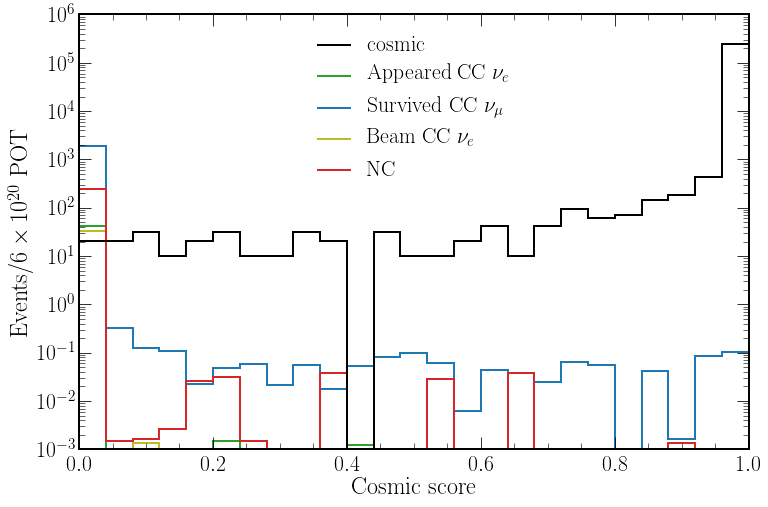

In [32]:
chipsnet.plotting.plot_cosmic_values(events, "final_cosmic", save_path+"final_cosmic_outputs")

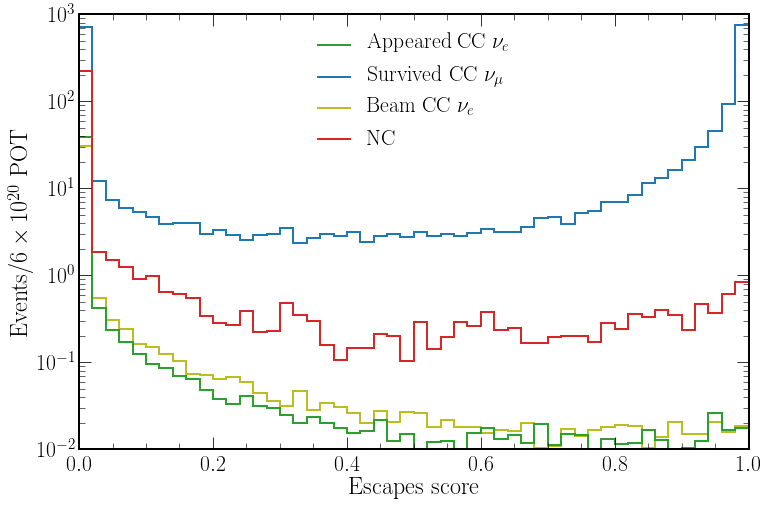

In [33]:
chipsnet.plotting.plot_escapes_values(events, "final_cosmic", save_path+"final_escapes_outputs")

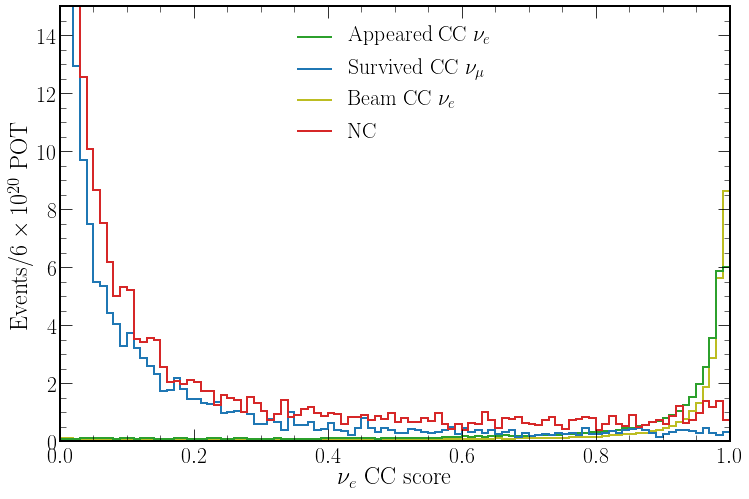

In [34]:
chipsnet.plotting.plot_combined_values(events, 0, "final_beam_", save_path+"final_beam_nuel_outputs")

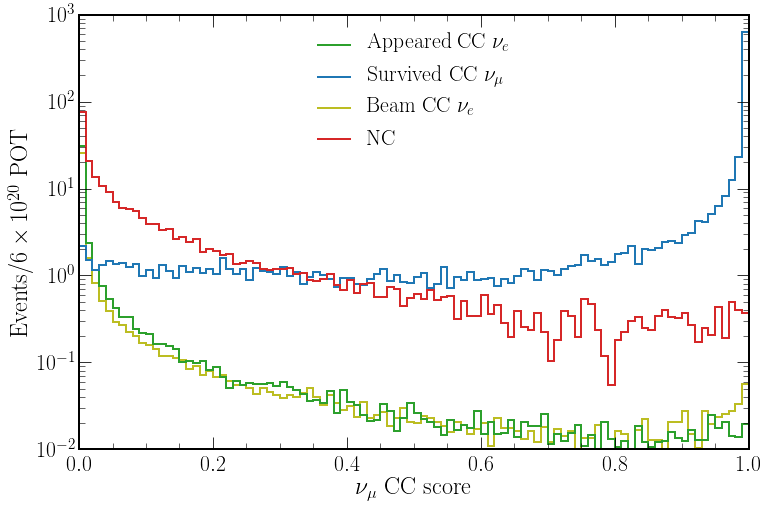

In [35]:
chipsnet.plotting.plot_combined_values(events, 1, "final_beam_", save_path+"final_beam_numu_outputs")

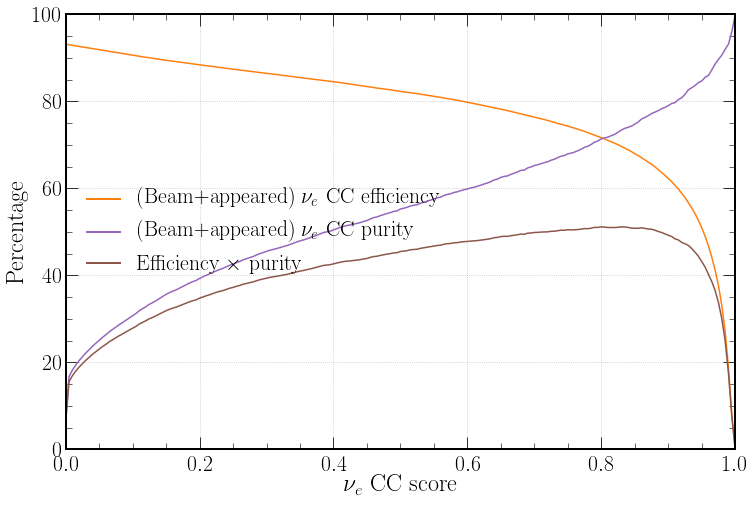

In [36]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 0, save_path+"final_nuel_eff_curves")

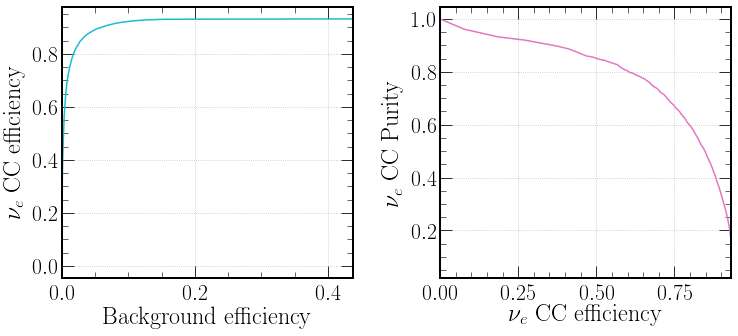

In [38]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 0, save_path+"final_nuel_comp_curves")

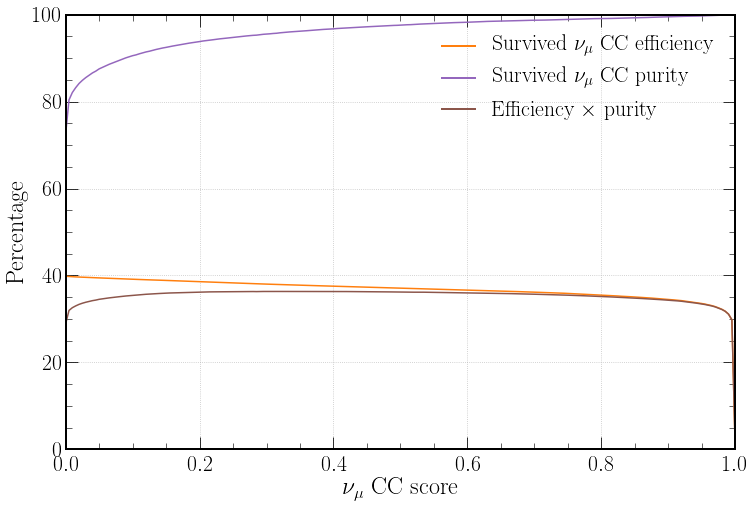

In [39]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 1, save_path+"final_numu_eff_curves", full=True)

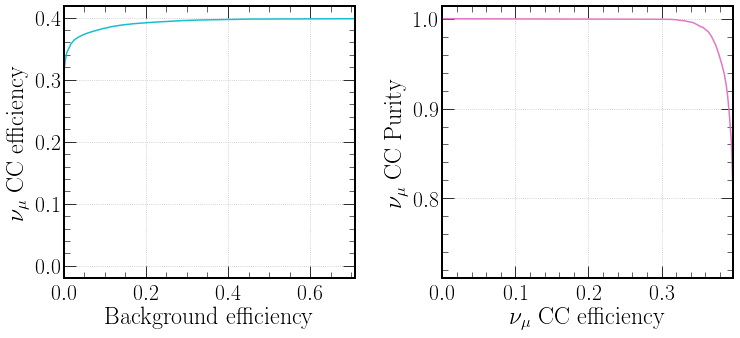

In [40]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 1, save_path+"final_numu_comp_curves")

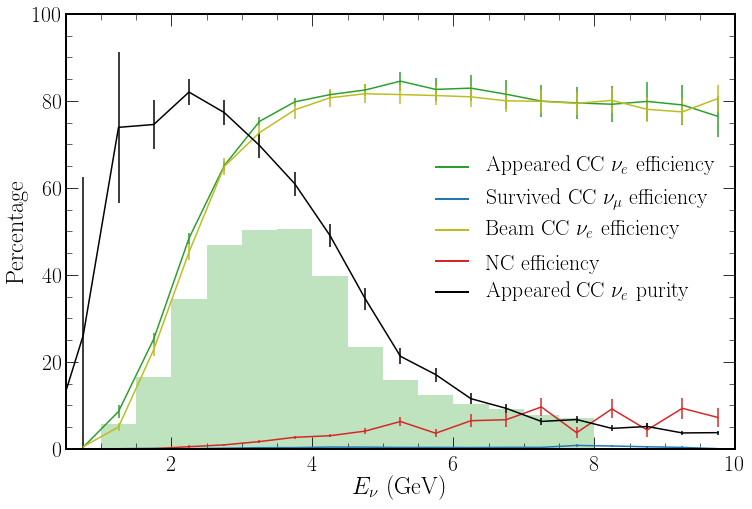

In [41]:
chipsnet.plotting.plot_nuel_hists([outputs[0]], events, save_path+"final_nuel_hists")

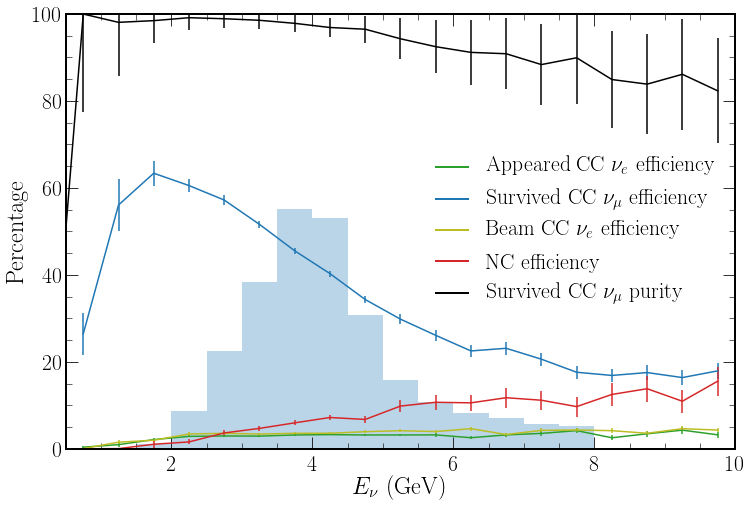

In [42]:
chipsnet.plotting.plot_numu_hists([outputs[0]], events, save_path+"final_numu_hists")

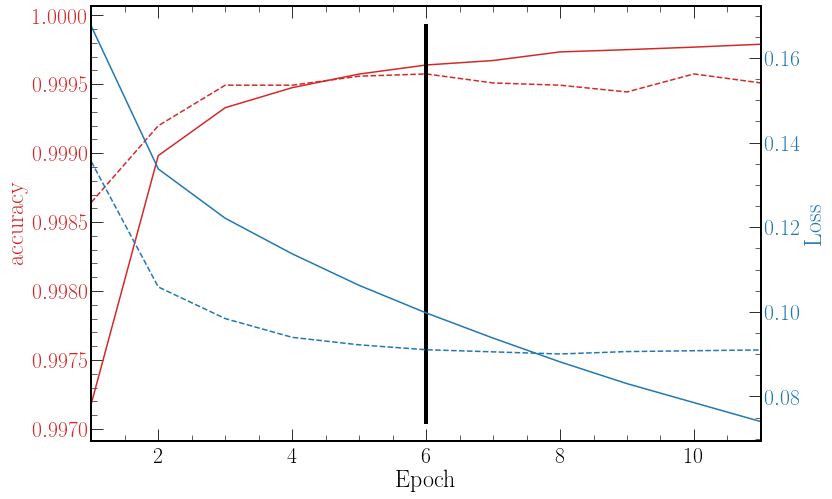

In [43]:
chipsnet.plotting.plot_history(config, "final_cosmic", save_path+"final_cosmic_history", key="t_cosmic_cat_accuracy")

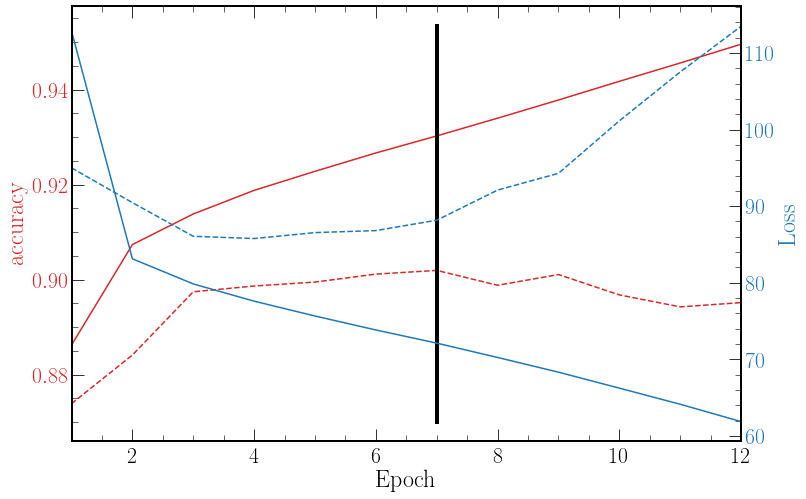

In [44]:
chipsnet.plotting.plot_history(config, "final_beam", save_path+"final_beam_history", key="t_comb_cat_accuracy")

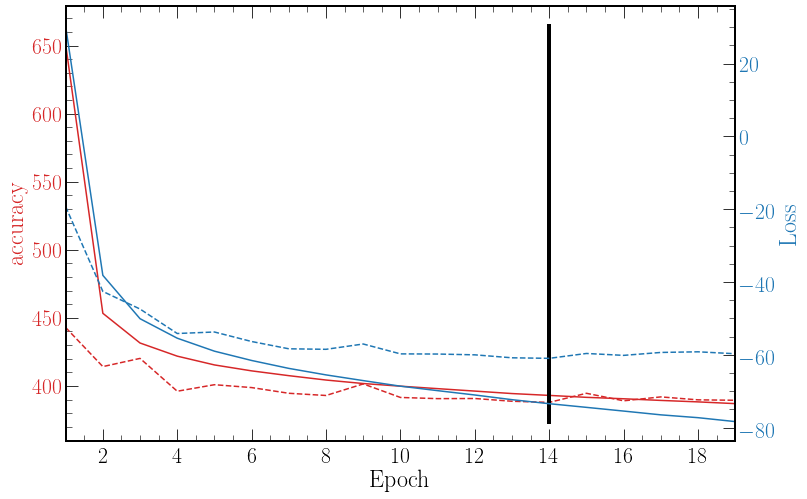

In [45]:
chipsnet.plotting.plot_history(config, "final_nuel_cc_e", save_path+"final_energy_history", key="t_nu_energy_mae", type="min")

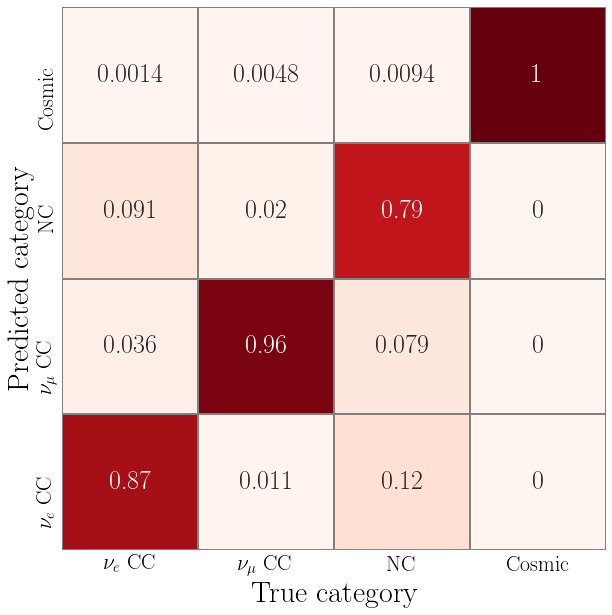

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    outputs[0]["comb_matrix"],
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
    yticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_comb_cat_confusion")

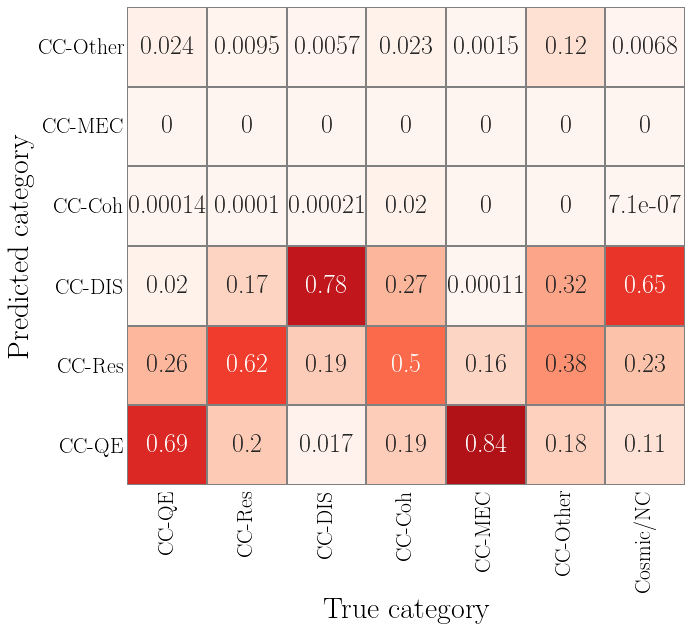

In [49]:
events["final_beam_t_cc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_cc_cat")["categories"], "final_beam_pred_t_cc_cat_"),
)
cc_matrix = confusion_matrix(
    events[events["nuel_selected"] | events["numu_selected"]]["t_cc_cat"],
    events[events["nuel_selected"] | events["numu_selected"]]["final_beam_t_cc_cat_class"],
    labels=[x for x in range(7)],
    sample_weight=events[events["nuel_selected"] | events["numu_selected"]]["w"],
    normalize="true",
)
cc_matrix = np.rot90(cc_matrix, 1)
cc_matrix = pd.DataFrame(cc_matrix)
cc_matrix = cc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    cc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_CC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_CC_CAT["labels"][:6][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_cc_cat_confusion")

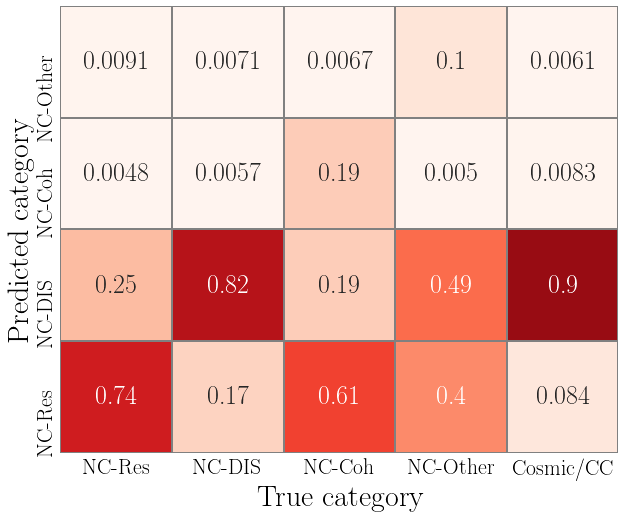

In [50]:
events["final_beam_t_nc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_nc_cat")["categories"], "final_beam_pred_t_nc_cat_"),
)
nc_matrix = confusion_matrix(
    events[events["nc_selected"]]["t_nc_cat"],
    events[events["nc_selected"]]["final_beam_t_nc_cat_class"],
    labels=[x for x in range(5)],
    sample_weight=events[events["nc_selected"]]["w"],
    normalize="true",
)
nc_matrix = np.rot90(nc_matrix, 1)
nc_matrix = pd.DataFrame(nc_matrix)
nc_matrix = nc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    nc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_NC_CAT["labels"][:4][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_nc_cat_confusion")

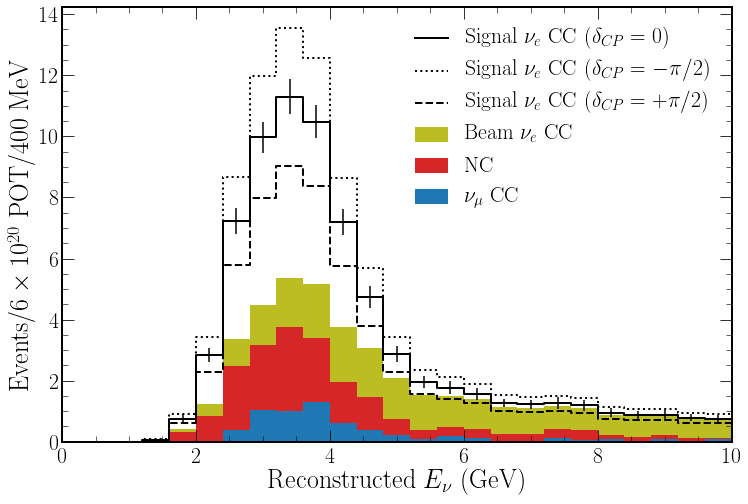

In [37]:
e_range=(0, 10)
e_bins=25
bin_range=(e_range[1]-e_range[0])/e_bins

numu_ev = events[(events["t_comb_cat"]==1) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)
nc_ev = events[(events["t_comb_cat"]==2) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["final_nuel_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["final_nuel_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["final_nuel_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["final_nuel_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = numu_err+nuel_o_err+nuel_b_err+nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)
axs.bar(bins, numu_h, bin_range, color="tab:blue")
axs.bar(bins, nc_h, bin_range, bottom=numu_h, color="tab:red")
axs.bar(bins, nuel_b_h, bin_range, bottom=nc_h+numu_h, color="tab:olive")
axs.bar(bins, nuel_o_h, bin_range, yerr=err, bottom=nuel_b_h+nc_h+numu_h, color="tab:green", alpha=0)

left,right = e[:-1],e[1:]
x = np.array([left,right]).T.flatten()
y = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
y_minus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h)*1.2,(numu_h+nuel_o_h+nuel_b_h+nc_h)*1.2]).T.flatten()
y_plus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h)*0.8,(numu_h+nuel_o_h+nuel_b_h+nc_h)*0.8]).T.flatten()
plt.plot(x,y, color="black", linewidth=2, linestyle="solid")
plt.plot(x,y_minus, color="black", linewidth=2, linestyle="dotted")
plt.plot(x,y_plus, color="black", linewidth=2, linestyle="dashed")

nuel = Patch(facecolor="tab:olive", label=r"Beam $\nu_{e}$ CC")
osc_nuel = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Signal $\nu_{e}$ CC ($\delta_{CP}=0$)")
#osc_nuel = Patch(facecolor="tab:green", label=r"Appeared CC $\nu_{e}$")
numu = Patch(facecolor="tab:blue", label=r"$\nu_{\mu}$ CC")
nc = Patch(facecolor="tab:red", label=r"NC")
minus = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label=r"Signal $\nu_{e}$ CC ($\delta_{CP}=-\pi/2$)")
plus = Line2D([0], [0], color="black", linewidth=2, linestyle="dashed", label=r"Signal $\nu_{e}$ CC ($\delta_{CP}=+\pi/2$)")
axs.legend(handles=[osc_nuel, minus, plus, nuel, nc, numu], loc="upper right")
axs.set(xlabel=r"Reconstructed $E_{\nu}$ (GeV)", ylabel=r"Events/$6\times10^{20}$ POT/400 MeV")
chipsnet.plotting.save(save_path + "final_nuel_passed_energy_dist")

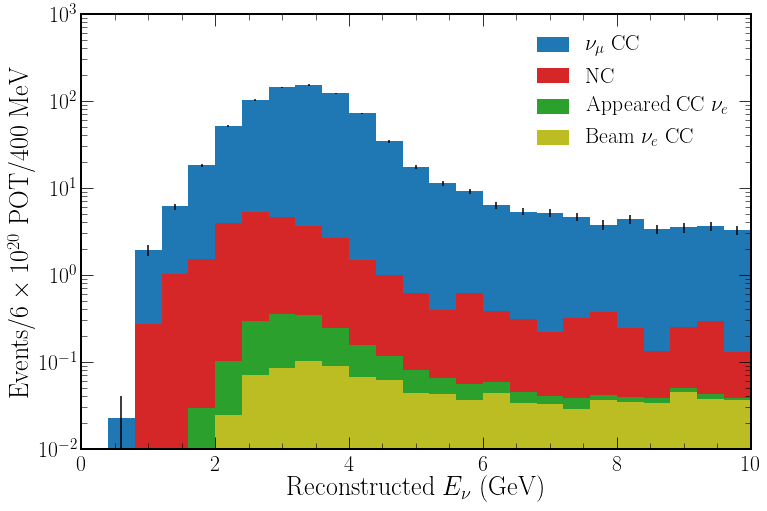

In [39]:
e_range=(0, 10)
e_bins=25
bin_range=(e_range[1]-e_range[0])/e_bins
escapes_cut=0.5

numu_ev = events[(events["t_comb_cat"]==1) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)
nuel_o_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["numu_selected"])].reset_index(drop=True)
nuel_b_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)
nc_ev = events[(events["t_comb_cat"]==2) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["final_numu_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["final_numu_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["final_numu_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["final_numu_cc_e_pred_t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = numu_err+nuel_o_err+nuel_b_err+nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)
axs.bar(bins, nuel_b_h, bin_range, color="tab:olive")
axs.bar(bins, nuel_o_h, bin_range, bottom=nuel_b_h, color="tab:green")
axs.bar(bins, nc_h, bin_range, bottom=nuel_o_h+nuel_b_h, color="tab:red")
axs.bar(bins, numu_h, bin_range, yerr=err, bottom=nc_h+nuel_o_h+nuel_b_h, color="tab:blue")
axs.set_yscale("log")
axs.set_ylim(10e-3, 10e2)

nuel = Patch(facecolor="tab:olive", label=r"Beam $\nu_{e}$ CC")
osc_nuel = Patch(facecolor="tab:green", label=r"Appeared CC $\nu_{e}$")
numu = Patch(facecolor="tab:blue", label=r"$\nu_{\mu}$ CC")
nc = Patch(facecolor="tab:red", label=r"NC")
axs.legend(handles=[numu, nc, osc_nuel, nuel], loc="upper right")
axs.set(xlabel=r"Reconstructed $E_{\nu}$ (GeV)", ylabel=r"Events/$6\times10^{20}$ POT/400 MeV")
chipsnet.plotting.save(save_path + "final_numu_passed_energy_dist")

In [40]:
out_80 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.8) & (events["frac_energy"] < 1.0)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_60 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.6) & (events["frac_energy"] < 0.8)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_40 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.4) & (events["frac_energy"] < 0.6)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_20 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.2) & (events["frac_energy"] < 0.4)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")

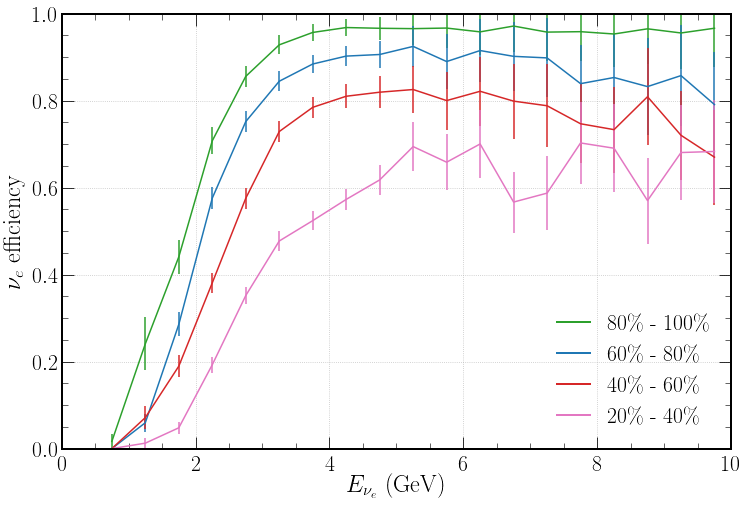

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0.25, 10.25, 0.5)
axs.errorbar(
    bins,
    out_80["fom_effs"][0][0][0],
    yerr=out_80["fom_effs"][0][0][1],
    color="tab:green"
)
axs.errorbar(
    bins,
    out_60["fom_effs"][0][0][0],
    yerr=out_60["fom_effs"][0][0][1],
    color="tab:blue"
)
axs.errorbar(
    bins,
    out_40["fom_effs"][0][0][0],
    yerr=out_40["fom_effs"][0][0][1],
    color="tab:red"
)
axs.errorbar(
    bins,
    out_20["fom_effs"][0][0][0],
    yerr=out_20["fom_effs"][0][0][1],
    color="tab:pink"
)
axs.set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=24)
axs.set_ylabel(r"$\nu_{e}$ efficiency", fontsize=24)
axs.set_ylim([0, 1])
leg_80 = Line2D([0], [0], color="tab:green", linewidth=2, label=r"80\% - 100\%")
leg_60 = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"60\% - 80\%")
leg_40 = Line2D([0], [0], color="tab:red", linewidth=2, label=r"40\% - 60\%")
leg_20 = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"20\% - 40\%")
axs.legend(handles=[leg_80, leg_60, leg_40, leg_20], loc="lower right")
axs.set_xlim(0, 10)
axs.grid()
chipsnet.plotting.save(save_path + "final_frac_energy_eff")

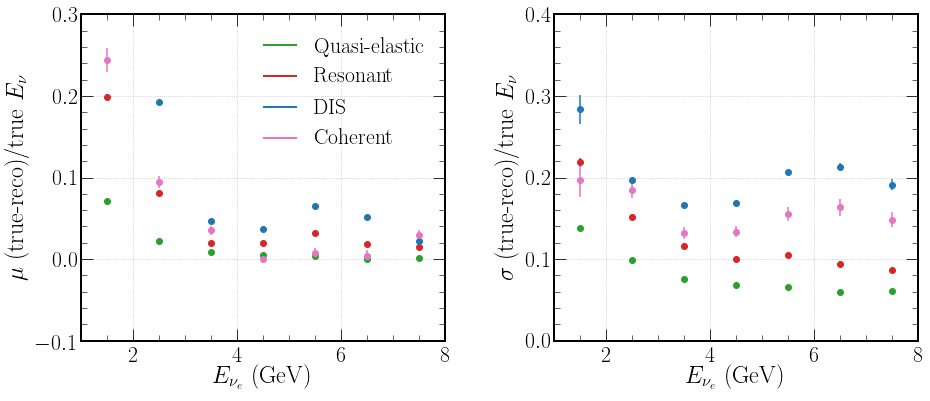

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 3)], fit_name="final_nuel_cccoh_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
#e_list, means, stds = chipsnet.utils.frac_e_vs_par(
#    events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_cc_e_frac_nu_energy"
#)
#axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="black", linestyle="", marker="o")
#axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")

axs[0].set_ylim(-0.1, 0.3)
axs[0].set_xlim(1, 8)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1, 8)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=24)
axs[0].set_ylabel(r"$\mu$ (true-reco)/true $E_{\nu}$", fontsize=24)
axs[1].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=24)
axs[1].set_ylabel(r"$\sigma$ (true-reco)/true $E_{\nu}$", fontsize=24)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"Quasi-elastic")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Resonant")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
coh = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"Coherent")
axs[0].legend(handles=[qel, res, dis, coh], loc="upper right")

chipsnet.plotting.save(save_path + "final_energy_nuel")

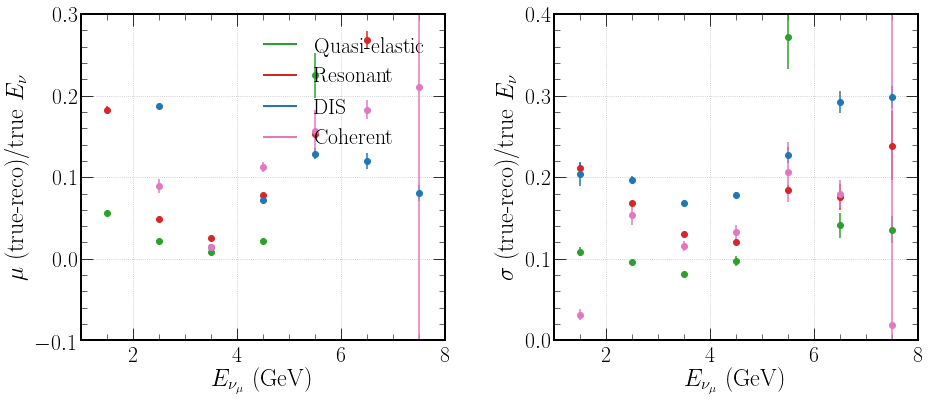

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_ccqel_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_ccres_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_ccdis_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 9)], fit_name="final_numu_cccoh_e_frac_nu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
#e_list, means, stds = chipsnet.utils.frac_e_vs_par(
#    events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_cc_e_frac_nu_energy"
#)
#axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="black", linestyle="", marker="o")
#axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")

axs[0].set_ylim(-0.1, 0.3)
axs[0].set_xlim(1, 8)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1, 8)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=24)
axs[0].set_ylabel(r"$\mu$ (true-reco)/true $E_{\nu}$", fontsize=24)
axs[1].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=24)
axs[1].set_ylabel(r"$\sigma$ (true-reco)/true $E_{\nu}$", fontsize=24)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"Quasi-elastic")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Resonant")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
coh = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"Coherent")
axs[0].legend(handles=[qel, res, dis, coh], loc="upper right")

chipsnet.plotting.save(save_path + "final_energy_numu")

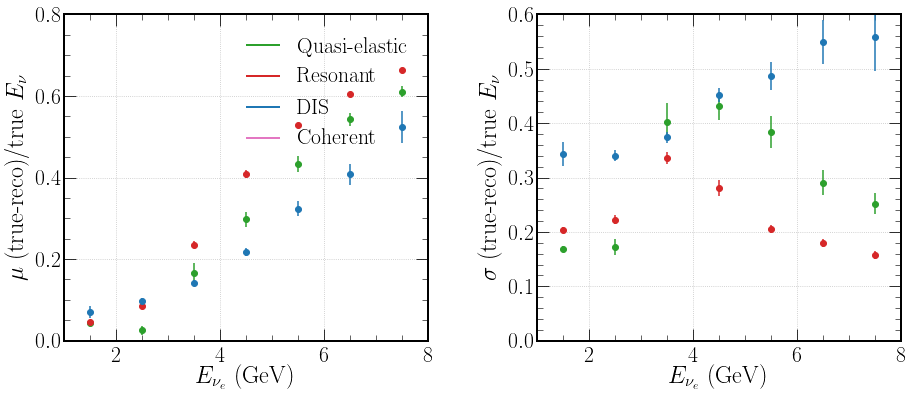

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 0)], 
    fit_name="final_nuel_ccqel_e_frac_lep_energy",
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 1)], 
    fit_name="final_nuel_ccres_e_frac_lep_energy",
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 2)],
    fit_name="final_nuel_ccdis_e_frac_lep_energy",
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
#e_list, means, stds = chipsnet.utils.frac_e_vs_par(
#    events[(events["nuel_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 3)],
#    fit_name="final_nuel_cccoh_e_frac_lep_energy",
#)
#axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
#axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
#e_list, means, stds = chipsnet.utils.frac_e_vs_par(
#    events[(events["nuel_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 0)],
#    fit_name="final_nuel_cc_e_frac_lep_energy",
#)
#axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="black", linestyle="", marker="o")
#axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")

axs[0].set_ylim(0.0, 0.8)
axs[0].set_xlim(1, 8)
axs[1].set_ylim(0.0, 0.6)
axs[1].set_xlim(1, 8)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=24)
axs[0].set_ylabel(r"$\mu$ (true-reco)/true $E_{\nu}$", fontsize=24)
axs[1].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=24)
axs[1].set_ylabel(r"$\sigma$ (true-reco)/true $E_{\nu}$", fontsize=24)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"Quasi-elastic")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Resonant")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
coh = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"Coherent")
axs[0].legend(handles=[qel, res, dis, coh], loc="upper right")

chipsnet.plotting.save(save_path + "final_energy_selected_nuel")

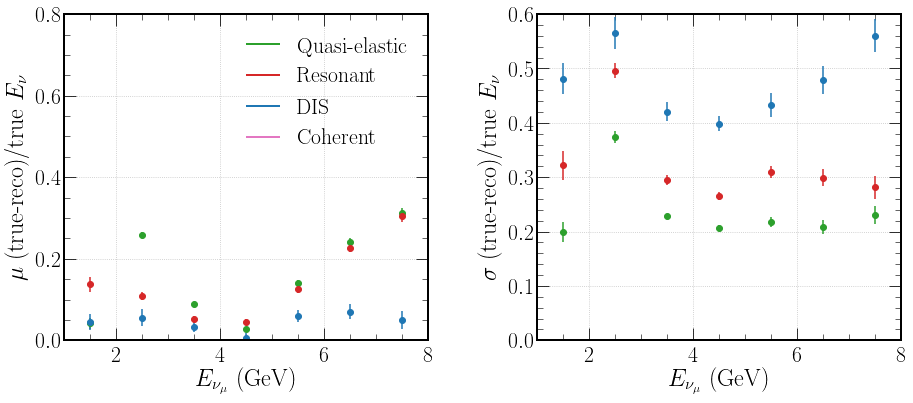

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 0)], 
    fit_name="final_numu_ccqel_e_frac_lep_energy",
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 1)], 
    fit_name="final_numu_ccres_e_frac_lep_energy",
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 2)],
    fit_name="final_numu_ccdis_e_frac_lep_energy",
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
#e_list, means, stds = chipsnet.utils.frac_e_vs_par(
#    events[(events["numu_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 3)],
#    fit_name="final_numu_cccoh_e_frac_lep_energy",
#)
#axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
#axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
#e_list, means, stds = chipsnet.utils.frac_e_vs_par(
#    events[(events["numu_selected"] == 0) & (events["final_beam_t_cc_cat_class"] == 0)],
#    fit_name="final_numu_cc_e_frac_lep_energy",
#)
#axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="black", linestyle="", marker="o")
#axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")

axs[0].set_ylim(0.0, 0.8)
axs[0].set_xlim(1, 8)
axs[1].set_ylim(0.0, 0.6)
axs[1].set_xlim(1, 8)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=24)
axs[0].set_ylabel(r"$\mu$ (true-reco)/true $E_{\nu}$", fontsize=24)
axs[1].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=24)
axs[1].set_ylabel(r"$\sigma$ (true-reco)/true $E_{\nu}$", fontsize=24)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"Quasi-elastic")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Resonant")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
coh = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"Coherent")
axs[0].legend(handles=[qel, res, dis, coh], loc="upper right")

chipsnet.plotting.save(save_path + "final_energy_selected_nuel")

In [88]:
scale=events[events["t_comb_cat"] == 0]["w"].sum()/old_events[old_events["l_type"]==11]["w"].sum()

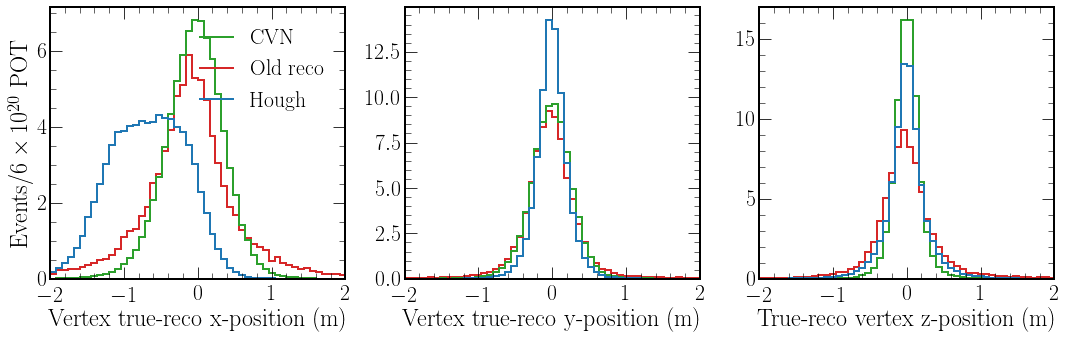

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(
    (old_events[old_events["l_type"]==11]["t_vtx_x"] - old_events[old_events["l_type"]==11]["r_vtx_x"]), 
    weights=old_events[old_events["l_type"]==11]["w"]*scale, 
    range=(-2, 2), bins=50, color='tab:red', histtype='step', linewidth=2
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]["t_vtx_x"]/100-events[events["t_comb_cat"] == 0]["final_nuel_cc_e_pred_t_vtx_x"]/100,
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step', linewidth=2
)
axs[0].hist(
    events[events["t_comb_cat"] == 0]["t_vtx_x"]/100-events[events["t_comb_cat"] == 0]["r_vtx_x"]*1250/100,
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:blue', histtype='step', linewidth=2
)
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=24)
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CVN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old reco")
hough = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"Hough")
axs[0].legend(handles=[cvn, old_reco, hough], loc="upper right")

axs[1].hist(
    (old_events[old_events["l_type"]==11]["t_vtx_y"] - old_events[old_events["l_type"]==11]["r_vtx_y"]), 
    weights=old_events[old_events["l_type"]==11]["w"]*scale,
    range=(-2, 2), bins=50, color='tab:red', histtype='step', linewidth=2
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]["t_vtx_y"]/100-events[events["t_comb_cat"] == 0]["final_nuel_cc_e_pred_t_vtx_y"]/100, 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step', linewidth=2
)
axs[1].hist(
    events[events["t_comb_cat"] == 0]["t_vtx_y"]/100-events[events["t_comb_cat"] == 0]["r_vtx_y"]*1250/100,
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:blue', histtype='step', linewidth=2
)
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=24)

axs[2].hist(
    (old_events[old_events["l_type"]==11]["t_vtx_z"] - old_events[old_events["l_type"]==11]["r_vtx_z"]), 
    weights=old_events[old_events["l_type"]==11]["w"]*scale,
    range=(-2, 2), bins=50, color='tab:red', histtype='step', linewidth=2
)
axs[2].hist(
    events[events["t_comb_cat"] == 0]["t_vtx_z"]/100-events[events["t_comb_cat"] == 0]["final_nuel_cc_e_pred_t_vtx_z"]/100, 
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step', linewidth=2
)
axs[2].hist(
    events[events["t_comb_cat"] == 0]["t_vtx_z"]/100-events[events["t_comb_cat"] == 0]["r_vtx_z"]*600/100,
    weights=events[events["t_comb_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:blue', histtype='step', linewidth=2
)
axs[2].set_xlabel('True-reco vertex z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "final_vertex_res_comparison")

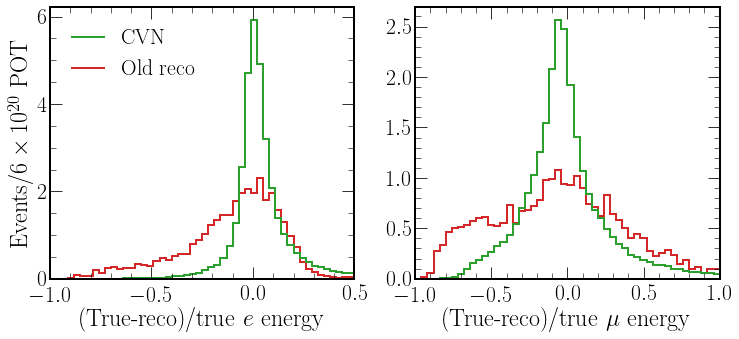

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"],
            range=(-1, 0.5), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs[0].hist(events[events["t_comb_cat"] == 0]["final_nuel_cc_e_frac_lep_energy"], 
            weights=events[events["t_comb_cat"] == 0]["w"],
            range=(-1, 0.5), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs[0].set_xlabel('(True-reco)/true $e$ energy', fontsize=24)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=24)

cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CVN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old reco")
axs[0].legend(handles=[cvn, old_reco], loc="upper left")

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["w"],
            range=(-1, 1), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs[1].hist(events[events["t_comb_cat"] == 1]["final_numu_cc_e_frac_lep_energy"], 
            weights=events[events["t_comb_cat"] == 1]["w"],
            range=(-1, 1), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs[1].set_xlabel('(True-reco)/true $\mu$ energy', fontsize=24)

chipsnet.plotting.save(save_path + "final_frac_lep_e_comparison")

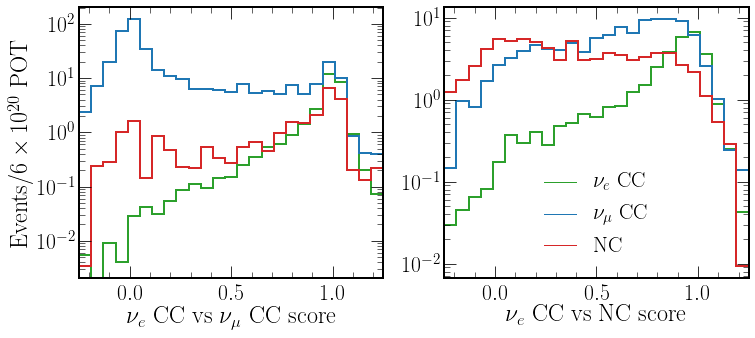

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:green', histtype='step', linewidth=2)
axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:blue', histtype='step', linewidth=2)
axs[0].hist(old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:red', histtype='step', linewidth=2)
axs[0].set_xlabel(r'$\nu_{e}$ CC vs $\nu_{\mu}$ CC score', fontsize=24)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=24)
axs[0].set_yscale("log")

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:green', histtype='step', linewidth=2)
axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:blue', histtype='step', linewidth=2)
axs[1].hist(old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:red', histtype='step', linewidth=2)
axs[1].set_xlabel(r'$\nu_{e}$ CC vs NC score', fontsize=24)
axs[1].set_yscale("log")

nuel = Line2D(
    [0],
    [0],
    color="tab:green",
    linewidth=1,
    linestyle="solid",
    label=r"$\nu_{e}$ CC",
)
numu = Line2D(
    [0],
    [0],
    color="tab:blue",
    linewidth=1,
    linestyle="solid",
    label=r"$\nu_{\mu}$ CC",
)
nc = Line2D([0], [0], color="tab:red", linewidth=1, linestyle="solid", label=r"NC")
axs[1].legend(handles=[nuel, numu, nc], loc="lower center")

chipsnet.plotting.save(save_path + "final_old_pid_outputs")

In [93]:
total_nuel = old_events[(old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
pass_nuel = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
pass_numu = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==13)]["w"].sum()
pass_nc = old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78) & (old_events["ann_vs_numu"] > 0.91)]["w"].sum()
print("Passed events-> Nuel: {:.5f}, Numu: {:.5f}, NC: {:.5f}".format(pass_nuel, pass_numu, pass_nc))
print("Nuel-> Eff: {:.5f}, Pur: {:.5f}".format(pass_nuel/total_nuel, pass_nuel/(pass_nuel+pass_numu+pass_nc)))

Passed events-> Nuel: 23.37463, Numu: 37.34422, NC: 13.84197
Nuel-> Eff: 0.38472, Pur: 0.31350


In [140]:
# Tidy up
del events, outputs

# Explainability and resilience

<a id='calib_factor'></a>

## Model calibration sensitivity: factor (calib_factor)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_factor_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_factor_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_factor_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_factor_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='calib_abs'></a>

## Model calibration sensitivity: abs (calib_abs)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_abs_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_abs_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_abs_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_abs_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='calib_noise'></a>

## Model calibration sensitivity: noise (calib_noise)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_noise_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_noise_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_noise_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_noise_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification
* 1
* 2
* 3

In [6]:
u_ev, u_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic", ["final_cosmic"], ["t_cosmic_cat"], exclude_images=False)
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)


************************ Evaluating sample_uniform_cosmic ************************
Loading best checkpoint (3)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (0,0.00000), (0,0.00000), (28919,0.11595), (0,0.00000), (16821,71.97538)
count    16821.000000
mean         0.999117
std          0.017473
min          0.039862
25%          0.999990
50%          0.999999
75%          1.000000
max          1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
Cuts:    (13649,0.93493), (19078,0.89425), (8555,0.76071), (0,0.00000)
took 28.49 seconds


In [7]:
pca_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Loading best checkpoint (3)
Explained variation per principal component: [0.39023102 0.25511444]


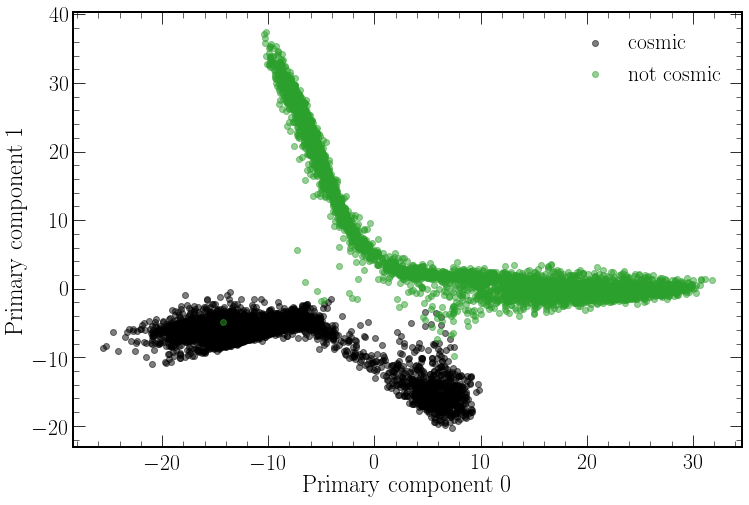

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_pca")

In [9]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Loading best checkpoint (3)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.079s...
[t-SNE] Computed neighbors for 10000 samples in 130.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.514210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.374168
[t-SNE] KL divergence after 300 iterations: 2.33

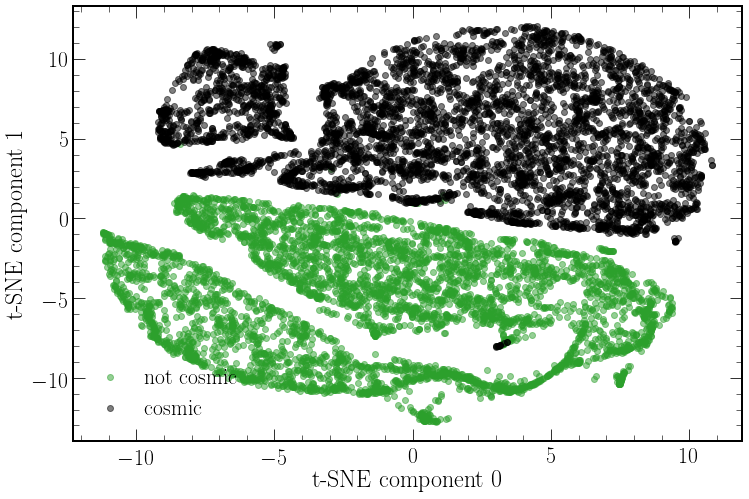

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_tsne")

In [11]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev

<a id='beam_cluster'></a>

## Clustering: beam classification
* 1
* 2
* 3

In [12]:
u_ev, u_out = chipsnet.utils.evaluate(config, "sample_uniform", ["final_beam"], ["t_comb_cat"], exclude_images=False)
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:4000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:4000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:4000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)


************************ Evaluating sample_uniform ************************
Loading best checkpoint (4)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (0,0.00000), (0,0.00000), (35042,0.09569), (0,0.00000), (0,0.00000)
Cuts:    (20439,0.97310), (25342,0.92479), (11534,0.73969), (0,0.00000)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.93680,0.66619), Rec: (0.86881,0.83908), F1: (0.89343,0.64896)
- Cat->  Prec: (0.93680,0.66619), Rec: (0.86881,0.83908), F1: (0.89343,0.64896)

- Nuel-> ROC-AUC: 0.84063, PRC-AUC: 0.46161, S-Eff: 0.91708, S-Pur: 0.16839
- FOM1-> 0.27120, 0.95000, 24.85778, 5.32770, 29.03369, 0.64608, 0.41976
- FOM2-> 4.35896, 0.97000, 20.80381, 2.99869, 19.77957, 0.54071, 0.47735

- Numu-> ROC-AUC: 0.67915, PRC-AUC: 0.92650, S-Eff: 0.86812, S-Pur: 0.97896
- FOM1-> 0.85555, 0.30500, 0.75866, 1588.07293, 60.44628, 0.88852, 0.96289
- FOM2-> 1060.54612, 0.99500, 0.00440, 1221.75371, 1.32271, 0.68357, 0.99891

took 46.44 seconds


In [13]:
pca_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

Loading best checkpoint (4)
Explained variation per principal component: [0.18732427 0.16578396]


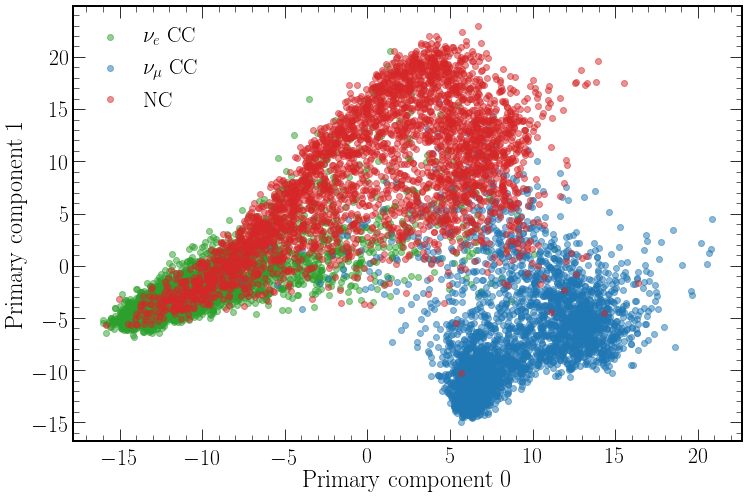

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.pca0, cat_2_ev.pca1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_pca")

In [15]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=12000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

Loading best checkpoint (4)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.513s...
[t-SNE] Computed neighbors for 12000 samples in 183.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma:

In [16]:
nuel_index = events["final_beam_pred_t_comb_cat_0"].idxmax()
numu_index = events["final_beam_pred_t_comb_cat_1"].idxmax()
nc_index = events["final_beam_pred_t_comb_cat_2"].idxmax()
print("Nuel: ({:.3f},{:.3f}), Numu: ({:.3f},{:.3f}), NC: ({:.3f},{:.3f})".format(
    events["tsne0"][nuel_index],
    events["tsne1"][nuel_index],
    events["tsne0"][numu_index],
    events["tsne1"][numu_index],
    events["tsne0"][nc_index],
    events["tsne1"][nc_index],
))
markers_0 = [events["tsne0"][nuel_index], events["tsne0"][numu_index], events["tsne0"][nc_index]]
markers_1 = [events["tsne1"][nuel_index], events["tsne1"][numu_index], events["tsne1"][nc_index]]

Nuel: (-0.440,-4.571), Numu: (-4.822,-2.076), NC: (-1.300,6.998)


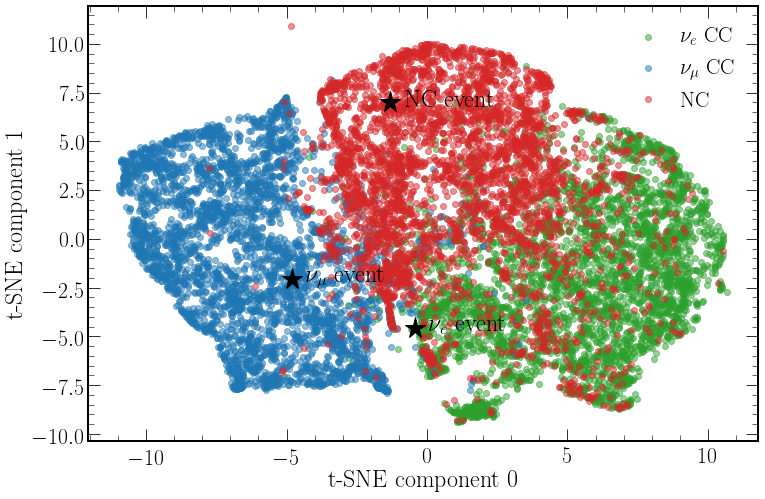

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.tsne0, cat_2_ev.tsne1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.plot(markers_0, markers_1, marker='*', linestyle='', ms=22, color="black")
axs.text(markers_0[0]+0.5, markers_1[0]-0.25, r"$\nu_{e}$ event", fontsize=24, weight="bold")
axs.text(markers_0[1]+0.5, markers_1[1]-0.25, r"$\nu_{\mu}$ event", fontsize=24, weight="bold")
axs.text(markers_0[2]+0.5, markers_1[2]-0.25, r"NC event", fontsize=24, weight="bold")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne")

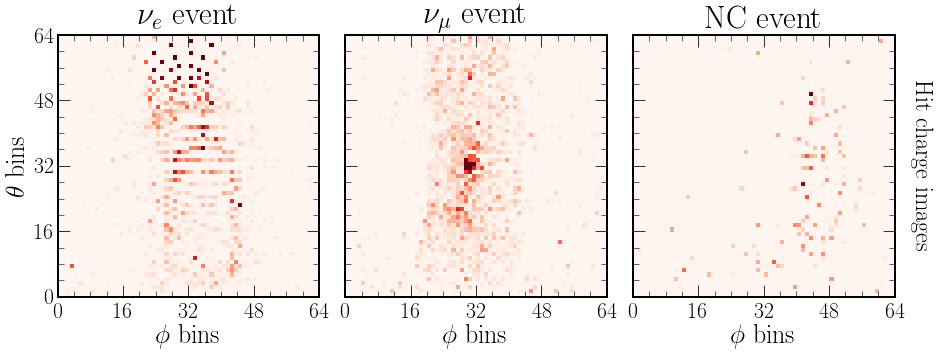

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][nuel_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"$\nu_{e}$ event")
axs[0].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[0].label_outer()
axs[1].imshow(events["image_0"][numu_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"$\nu_{\mu}$ event")
axs[1].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[1].label_outer()
axs[2].imshow(events["image_0"][nc_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"NC event")
axs[2].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[2].label_outer()
axs[2].text(68, 12, "Hit charge images", rotation=-90, fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne_events")

In [19]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev, cat_2_ev

<a id='explain'></a>

## Explanation: cosmic/beam/energy (explain)
* 1
* 2
* 3

In [20]:
num_events = 10
test_event = 7
events, outputs = chipsnet.utils.evaluate(config, "stacked_noreco")
cosmic_model = chipsnet.utils.model_from_conf(config, "explain_cosmic")
beam_model = chipsnet.utils.model_from_conf(config, "explain_beam")
energy_model = chipsnet.utils.model_from_conf(config, "explain_energy")


************************ Evaluating stacked_noreco ************************
Weights: (4851,0.00801), (4171,0.00061), (15136,0.22154), (1665,0.04406), (18578,65.16836)
Cuts:    (23344,0.95216), (13298,0.91799), (4330,0.67456), (3805,0.20481)
took 11.61 seconds
Loading best checkpoint (9)
Loading best checkpoint (10)
Loading best checkpoint (5)


In [21]:
# Explain cosmic model
cosmic_gc_1 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_gc_2 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_gc_3 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_gc_1 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
beam_gc_2 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
beam_gc_3 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block2_conv1")

KeyError: 'image_0'

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(cosmic_gc_1[test_event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(cosmic_gc_2[test_event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(cosmic_gc_3[test_event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "explain_cosmic_gradcam")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(beam_gc_1[test_event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(beam_gc_2[test_event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(beam_gc_3[test_event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "explain_beam_gradcam")

In [ ]:
# Explain cosmic model
cosmic_activ_1 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_activ_2 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_activ_3 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_activ_1 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
beam_activ_2 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
beam_activ_3 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block2_conv1")

# Explain energy model
energy_activ_1 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block0_path0_conv1")
energy_activ_2 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block1_path0_conv1")
energy_activ_3 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block2_conv1")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(cosmic_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(cosmic_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(cosmic_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_cosmic_activations")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(beam_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(beam_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(beam_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_beam_activations")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(energy_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(energy_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(energy_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_energy_activations")

In [ ]:
# Tidy up
del events, outputs, cosmic_model, beam_model, energy_model
del cosmic_gc_1, cosmic_gc_2, cosmic_gc_3
del beam_gc_1, beam_gc_2, beam_gc_3
del cosmic_activ_1, cosmic_activ_2, cosmic_activ_3
del beam_activ_1, beam_activ_2, beam_activ_3
del energy_activ_1, energy_activ_2, energy_activ_3